# COVID-19 Mitigation Measures Collateral Damage Assesment 

In this project i will determine which factors are most relevant for the reprodduction of the SARS-CoV2 virus in Austria, built a SIR-based model to simulate various scenarios for different stringency of mitigation measures and then try to estimate the collateral damage by said measures. End product is an estimate for collateral damage of measures and effectiveness in containing the virus

In [1]:
import os
import requests
from pprint import pprint
import covsirphy as cs
import pandas as pd
import numpy as np
import datetime
from operator import add

import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import ttest_ind
from scipy import signal
from scipy.stats import boxcox

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_log_error


import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27*0.75)})

In [2]:
# Some Sources:
# https://www.who.int/bulletin/online_first/BLT.20.265892.pdf
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333368/

## 1. Data Preparation and Exploration

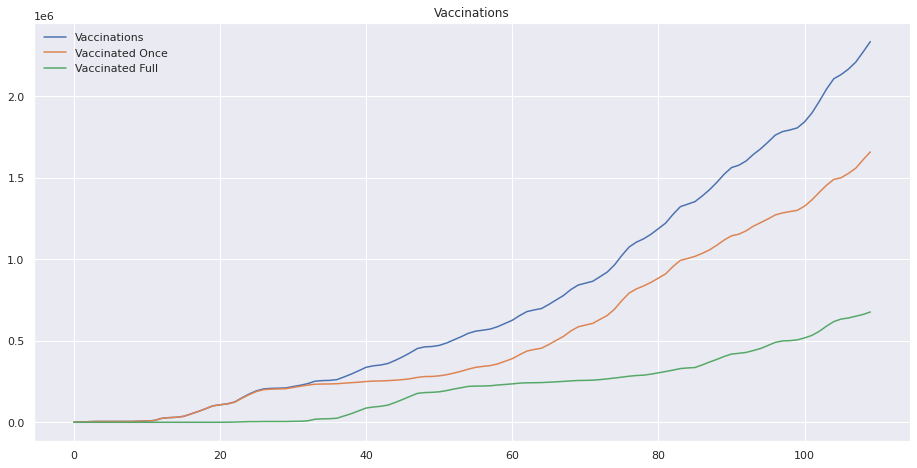

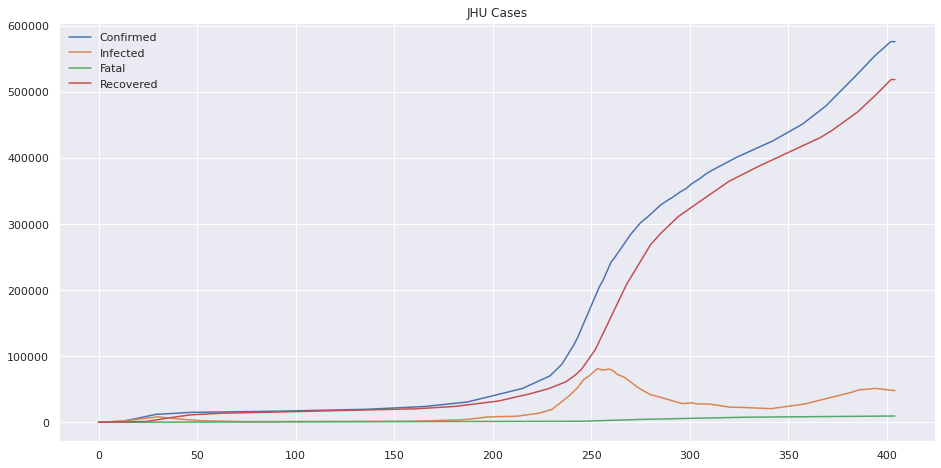

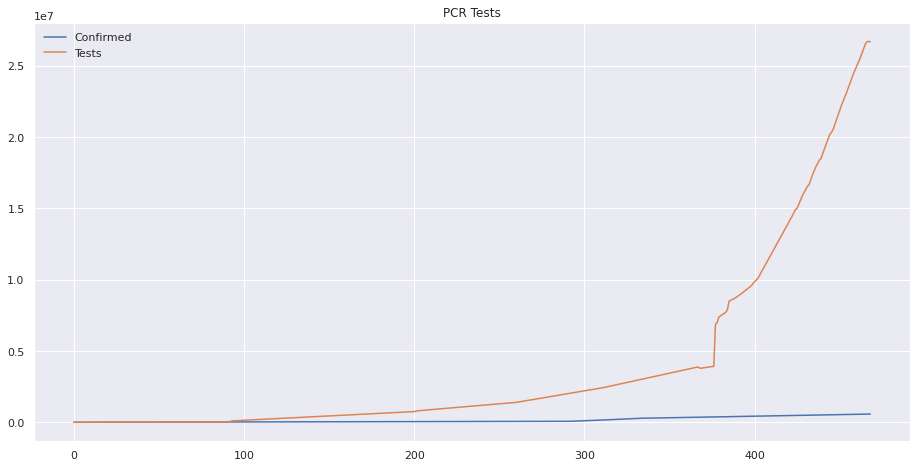

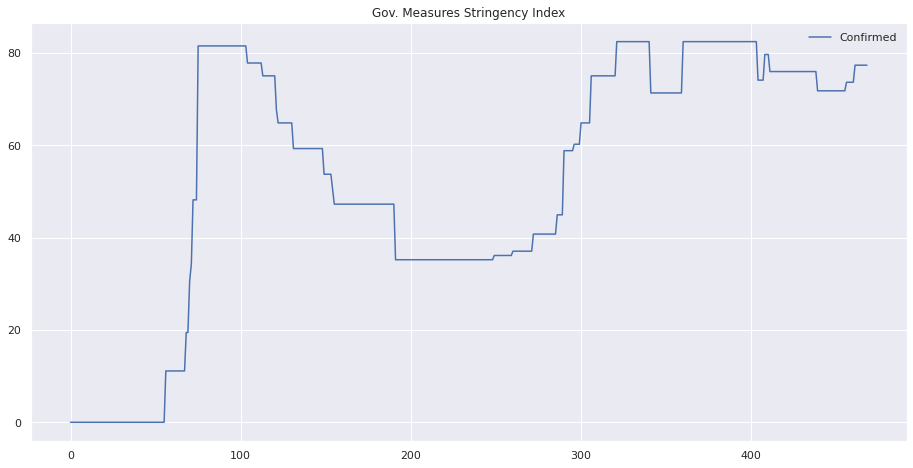

In [3]:
#Get data
data_loader = cs.DataLoader("../input")
jhu_data = data_loader.jhu() #Cases (JHU)
population_data = data_loader.population() # Population
oxcgrt_data = data_loader.oxcgrt() # Government Response (OxCGRT)
pcr_data = data_loader.pcr() # Tests
vaccine_data = data_loader.vaccine() # Vaccinations
#print(vaccine_data.subset("Austria"))
plt.plot(vaccine_data.subset("Austria")['Vaccinations'], label='Vaccinations')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_once'], label='Vaccinated Once')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_full'], label='Vaccinated Full')
plt.title('Vaccinations')
plt.legend()
plt.show()

#print(jhu_data.subset("Austria"))
plt.plot(jhu_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(jhu_data.subset("Austria")['Infected'], label='Infected')
plt.plot(jhu_data.subset("Austria")['Fatal'], label='Fatal')
plt.plot(jhu_data.subset("Austria")['Recovered'], label='Recovered')
plt.title('JHU Cases')
plt.legend()
plt.show()

#print(pcr_data.subset("Austria"))
plt.plot(pcr_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(pcr_data.subset("Austria")['Tests'], label='Tests')
plt.title('PCR Tests')
plt.legend()
plt.show()

#print(oxcgrt_data.subset("Austria"))
plt.plot(oxcgrt_data.subset("Austria")['Stringency_index'], label='Confirmed')
plt.title('Gov. Measures Stringency Index')
plt.legend()
plt.show()

country = "Austria"
aut_cov = jhu_data.subset("Austria")
aut_pop = population_data.subset("Austria")
aut_gov = oxcgrt_data.subset("Austria")
aut_pcr = pcr_data.subset("Austria")
aut_vac = vaccine_data.subset("Austria") 

age 0 to 9
age 10 to 19
age 20 to 29
age 30 to 39
age 40 to 49
age 50 to 59
age 60 to 69
age 70 to 79
age 80 to 89
age 90 to 99
age 100 to 109
8901064
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              49.00
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    7.65e-05
Time:                        16:13:12   Log-Likelihood:                          17.143
No. Observations:                   9   AIC:                                     -30.29
Df Residuals:                       7   BIC:                                     -29.89
Df Model:                           2                                                  
Covariance Type:            nonrobust                    

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


AltersgruppeID
1        [<5]
2      [5-14]
3     [15-24]
4     [25-34]
5     [35-44]
6     [45-54]
7     [55-64]
8     [65-74]
9     [75-84]
10      [>84]
Name: Altersgruppe, dtype: object
                Anzahl AnzahlGeheilt AnzahlTot AnzEinwohner Altersgruppe  \
AltersgruppeID                                                             
1                 6746          5985         0       435835         [<5]   
2                42509         38099         1       847225       [5-14]   
3                83700         77312         6       955625      [15-24]   
4                94770         87700        11      1209030      [25-34]   
5                88500         81666        26      1174745      [35-44]   
6               102765         95420       135      1333857      [45-54]   
7                78712         72747       500      1251120      [55-64]   
8                38168         34035      1307       842035      [65-74]   
9                31758         26583      3292     

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


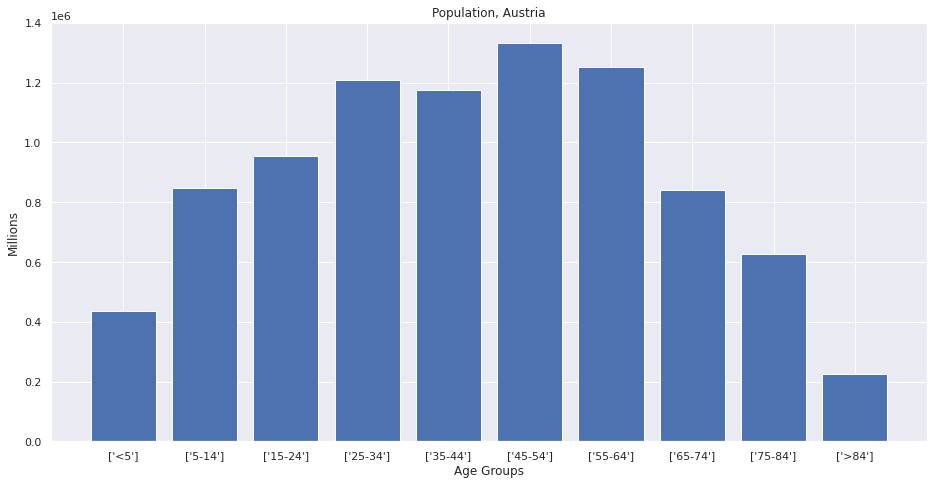

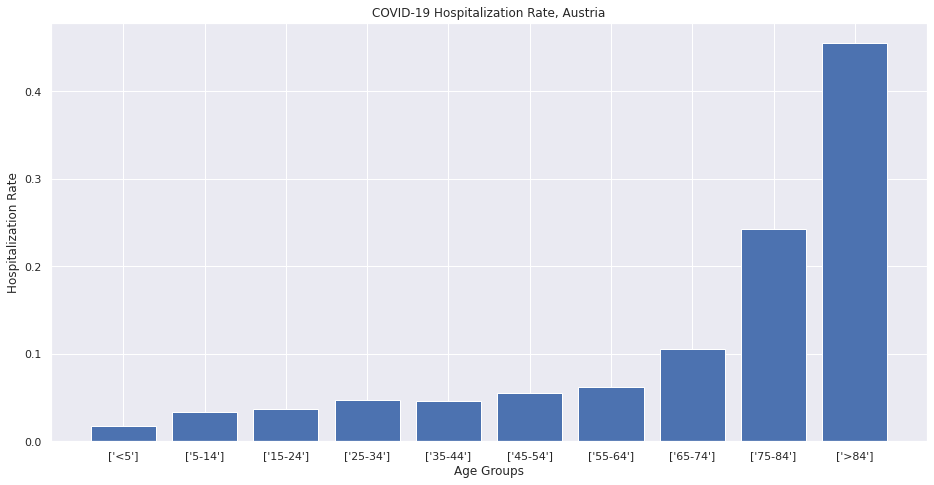

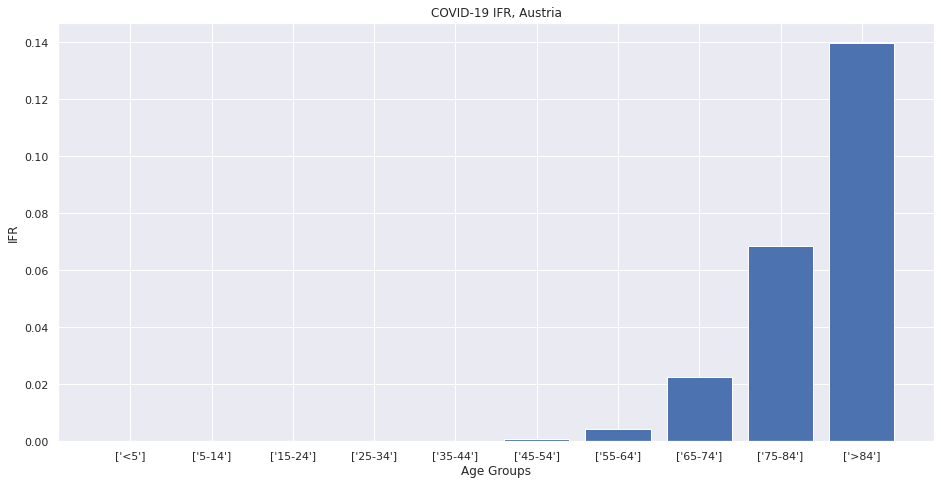

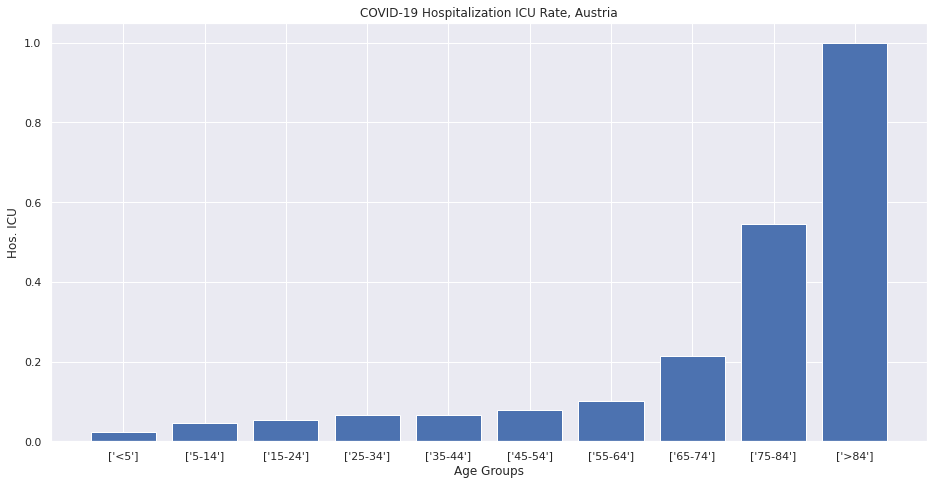

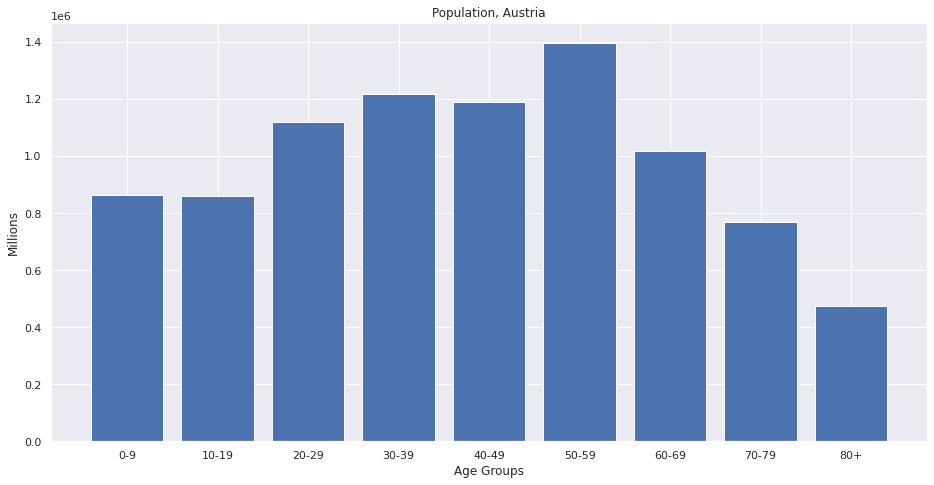

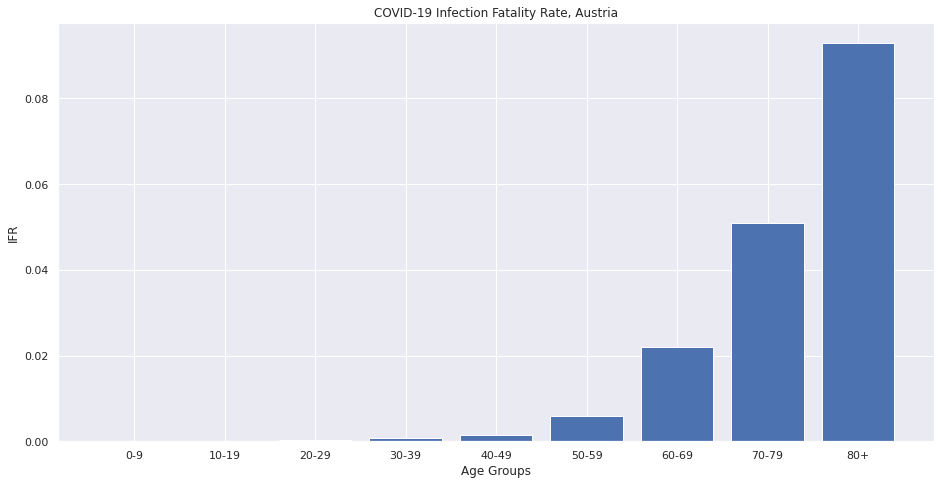

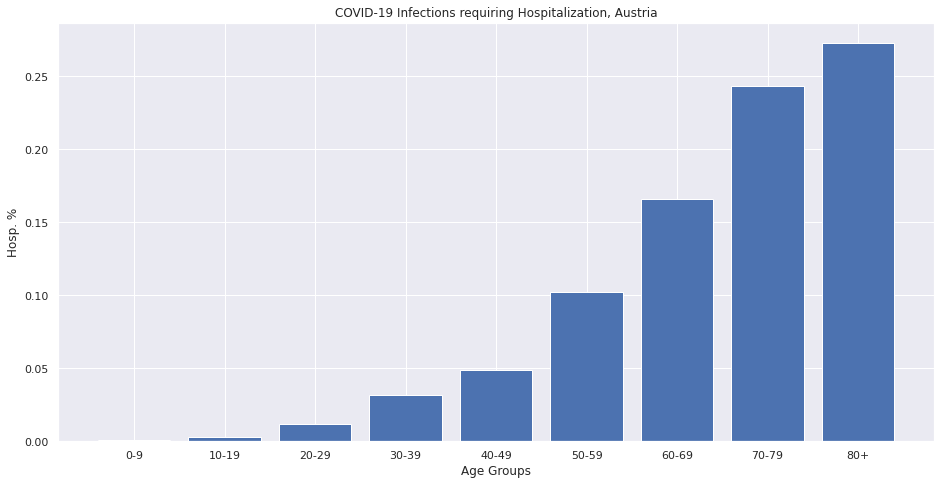

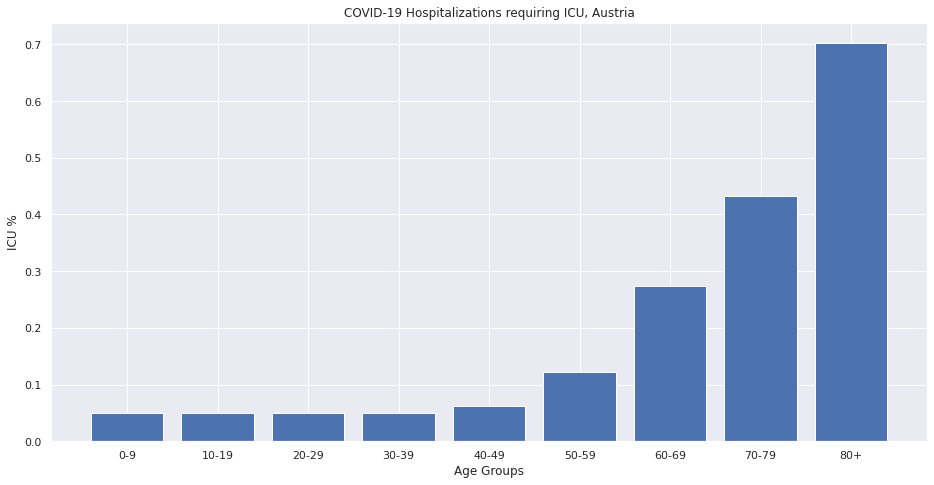

In [43]:
'''
Für die Todesrate von Krankheiten gibt es laut WHO zwei verschiedene wichtige Kennzahlen. 
Mit dem „Fall-Verstorbenen-Anteil” (CFR) wird berechnet, wie viele Todesfälle unter 
allen positiv getesteten Erkrankten zu verzeichnen sind. 
Beim „Infizierten-Verstorbenen-Anteil” (IFR) wird die Zahl der Todesfälle der geschätzten Zahl 
an Gesamtinfizierten gegenübergestellt. Dadurch werden auch Infizierte erfasst, 
die keine oder kaum Symptome aufzeigen und nicht getestet wurden.
'''

# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf

from zipfile import ZipFile
# Population
# https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/bevoelkerungsstruktur/bevoelkerung_nach_alter_geschlecht/index.html
dfs = pd.read_excel("./data/bevoelkerung_am_1.1.2020_nach_alter_und_bundesland_-_insgesamt.xlsx", sheet_name=None)
dfs = dfs['Insgesamt'][['Bevölkerung am 1.1.2020 nach Alter und Bundesland - Insgesamt', 'Unnamed: 1']].loc[4:104]
dfs = dfs.reset_index(drop=True)

pop_groups = []
for i in range(0,104,10):
    print('age',i,'to',i+9)
    pop_groups.append(dfs['Unnamed: 1'].loc[i:i+9].sum())

pp80 = sum(pop_groups[-3:])
pop_groups = pop_groups[:-3]
pop_groups.append(pp80)
assert(sum(pop_groups)==dfs['Unnamed: 1'].sum())
print(sum(pop_groups))

#Some Data from birtain -  we will try to obtain hosp rates, icu rates from that data for austria
# Source:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
pop_groups_ifr = [0.00002, 0.00006, 0.0003, 0.0008, 0.0015, 0.006, 0.022, 0.051, 0.093]
pop_groups_hosp = [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]
pop_groups_hosp_icu = [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.274, 0.432, 0.703]

#print(pop_groups)
#print(pop_groups_ifr)
#print(pop_groups_hosp)
#print(pop_groups_hosp_icu)

mod = sm.OLS(pop_groups_hosp, np.array([pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
#res.predict(np.array([pop_groups_ifr, pop_groups]).T)
        
# Get IFRs, etc for austria
# https://flexikon.doccheck.com/de/Infection_fatality_rate
url = 'https://covid19-dashboard.ages.at/data/data.zip'
save_path = './data/ages/data.zip'

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url, save_path)
with ZipFile('./data/ages/data.zip', 'r') as zipObj:
    zipObj.extractall(path='./data/ages/')

aut_age_groups = pd.read_csv("./data/ages/CovidFaelle_Altersgruppe.csv", sep=';', index_col = 0, header = 0)

print(aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique())


aut_age_groups = pd.DataFrame(
    [aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Anzahl.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlGeheilt.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlTot.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzEinwohner.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique()
    ]
).T#.reset_index(drop=True)

aut_age_groups['CFR'] = aut_age_groups.AnzahlTot/aut_age_groups.Anzahl
aut_age_groups['IFR'] = aut_age_groups['CFR']*(1-0.34)
aut_age_groups['Hosp'] = np.clip(
    res.predict(np.array([aut_age_groups['IFR'], aut_age_groups['AnzEinwohner']]).T),
    0.0,1.0)
print(aut_age_groups)

aut_hosp_groups = pd.read_csv("./data/ages/CovidFallzahlen.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} )

print(aut_hosp_groups.head(15))

aut_hosp_groups = pd.DataFrame(
    [aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZHosp.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZHospFree.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZICU.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZICUFree.sum(),
    ]
).T

#plt.plot([9, 66])
#print(aut_hosp_groups['FZHosp'], aut_age_groups)




mod = sm.OLS(pop_groups_hosp_icu, np.array([pop_groups_hosp, pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
aut_age_groups['Hosp_ICU'] = np.clip(res.predict(np.array([
                                aut_age_groups['Hosp'],
                                aut_age_groups['IFR'], 
                                aut_age_groups['AnzEinwohner']]).T), 0.0, 1.0)
    

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)

plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, aut_age_groups['AnzEinwohner'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()


plt.xlabel('Age Groups')
plt.ylabel('Hospitalization Rate')
plt.title('COVID-19 Hospitalization Rate, Austria')
plt.bar(x, aut_age_groups['Hosp'], 
        tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 IFR, Austria')
plt.bar(x, aut_age_groups['IFR'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('Hos. ICU')
plt.title('COVID-19 Hospitalization ICU Rate, Austria')
plt.bar(x, aut_age_groups['Hosp_ICU'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()



x = np.linspace(0, len(pop_groups), len(pop_groups), endpoint=False, dtype=int)
groups_labels = ["{}-{}".format(i, i+9) for i in range(0,90,10)][:-1]+['80+']
plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, pop_groups, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 Infection Fatality Rate, Austria')
plt.bar(x, pop_groups_ifr, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('Hosp. %')
plt.title('COVID-19 Infections requiring Hospitalization, Austria')
plt.bar(x, pop_groups_hosp, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('ICU %')
plt.title('COVID-19 Hospitalizations requiring ICU, Austria')
plt.bar(x, pop_groups_hosp_icu, tick_label=groups_labels)
plt.show()

        
pop_groups_hosp_icu = aut_age_groups['Hosp_ICU'].to_numpy()
pop_groups_hosp = aut_age_groups['Hosp'].to_numpy()
pop_groups_ifr = aut_age_groups['IFR'].to_numpy()
pop_groups = aut_age_groups['AnzEinwohner'].to_numpy()


         Date  Vaccinations  Vaccinated_once  Vaccinated_full
0  2020-12-27           732              732                0
1  2020-12-28          2029             2029                0
2  2020-12-29          3648             3648                0
3  2020-12-30          4996             4996                0
4  2020-12-31          5004             5004                0
5  2021-01-01          5008             5008                0
6  2021-01-02          5014             5014                0
7  2021-01-03          5015             5015                0
8  2021-01-04          5131             5131                0
9  2021-01-05          6921             6921                0
10 2021-01-06          7754             7754                0
11 2021-01-07         10930            10930                0
12 2021-01-08         23886            23886                0
13 2021-01-09         28289            28289                0
14 2021-01-10         30509            30509                0
15 2021-

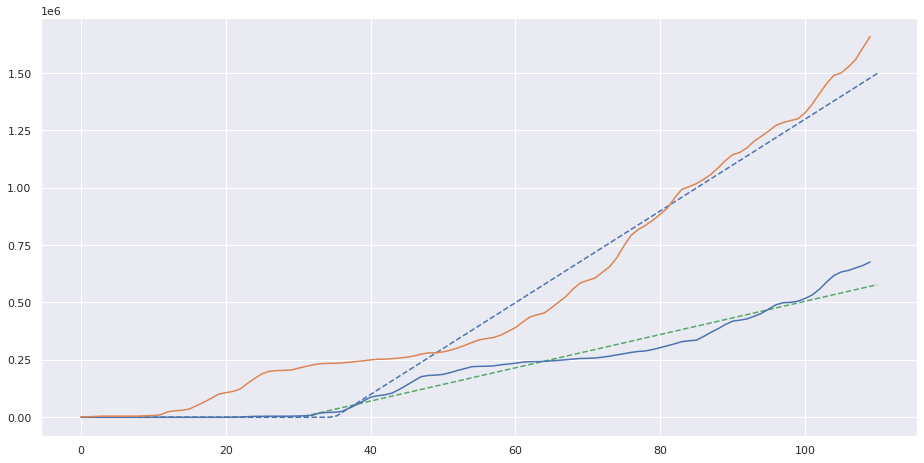

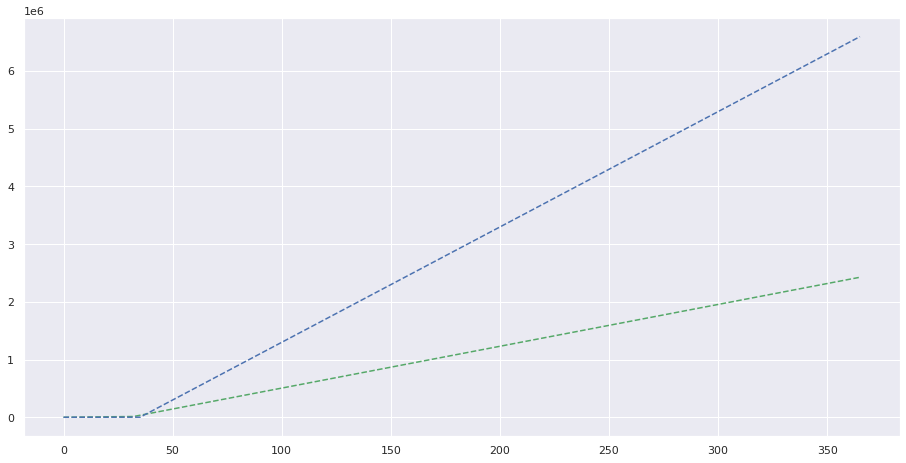

20033.016152648255 7263.294717780314


In [98]:
# Vaccines
print(aut_vac.head(25))
vac_full_data = aut_vac['Vaccinated_full'].to_numpy()
vac_once_data = aut_vac['Vaccinated_once'].to_numpy()
# plt.plot(aut_vac['Vaccinated_full'].to_numpy())

# Start Date is 2020-12-27 for vaccinated once, 
# 2021-01-15 for vaccinated
# 307 days and XXX days after start of pandemic in Austria on 25.02.2020

# Next we fit a 4th degree polynomial to the vaccinations curve using least squares method
# so we can estimate future vaccinations progress.

#poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**2) + e
#def func(x, a, b, c, d, e):
#    y = poly4(x, a, b, c, d, e)
#    return np.abs(y*(y>0))
    
#poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0) 
#def func(x, a, b, c, d):
#    y = poly3(x, a, b, c, d)
#    return np.abs(y*(y>0))

#poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
#def func(x, a, b, c):
#    y = poly2(x, a, b, c)
#    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_full(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_once(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))
    
    

xdata = np.linspace(0,1,len(vac_full_data))*len(vac_full_data)
popt_full, pcov_full = curve_fit(vac_full, xdata, vac_full_data, method='lm')

xdata = np.linspace(0,1,len(vac_once_data))*len(vac_once_data)
popt_once, pcov_once = curve_fit(vac_once, xdata, vac_once_data, method='lm')

# Check quality of fit with R2
print(r2_score(vac_full(xdata, *popt_full), vac_full_data))
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.plot(vac_full_data)
plt.plot(vac_once_data)
plt.show()

# Predict a whole year of vaccinations and see how it looks like:
dur = 365
xdata = np.linspace(0,1,dur)*dur
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.show()

vac_full_curve = vac_full(xdata, *popt_full)
vac_full_per_day = vac_full_curve[-1]-vac_full_curve[-2]

vac_once_curve = vac_once(xdata, *popt_once)
vac_once_per_day = vac_once_curve[-1]-vac_once_curve[-2]
print(vac_once_per_day, vac_full_per_day)

               R_eff  R_eff_lwr  R_eff_upr
Datum                                     
2020-03-10  2.724623   2.364393   3.110021
2020-03-11  3.158794   2.817445   3.519379
2020-03-12  3.073370   2.781653   3.379425
2020-03-13  3.266824   3.007643   3.536563
2020-03-14  3.214620   2.994746   3.442174


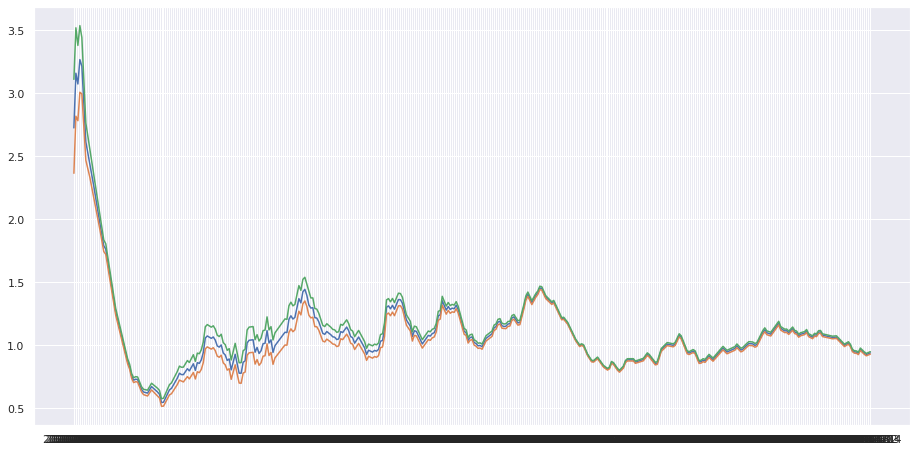

In [87]:
# Effective reproduction number, etc AGES
# https://www.ages.at/en/wissen-aktuell/publikationen/epidemiologische-parameter-des-covid19-ausbruchs-oesterreich-20202021/

urls = ['https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/growth.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/meta_data.csv'
    ]

for url in urls:
    with open('./data/ages/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

aut_reff = pd.read_csv("./data/ages/R_eff.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} ) 
aut_reff[0:]=aut_reff[0:].replace({',' : '.'}, regex=True).astype(float)
print(aut_reff.head())

plt.plot(aut_reff['R_eff'], label='R_eff')
plt.plot(aut_reff['R_eff_lwr'], label='R_eff_lwr')
plt.plot(aut_reff['R_eff_upr'], label='R_eff_upr')
plt.show()

Int64Index([202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
            202011, 202012, 202101, 202102, 202103],
           dtype='int64', name='REF_DATE')
Index(['NUTS1', 'NUTS2', 'NUTS3', 'DISTRICT_CODE', 'SUB_DISTRICT_CODE', 'T',
       'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'NUM_ICE',
       'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H', 'NUM_CLEAR',
       'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN', 'WIND_VEL',
       'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01',
       'STAT_NUM', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


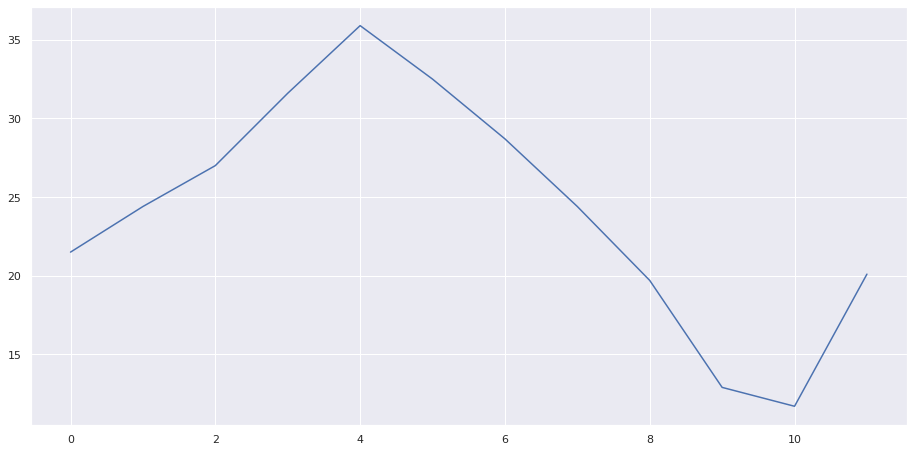

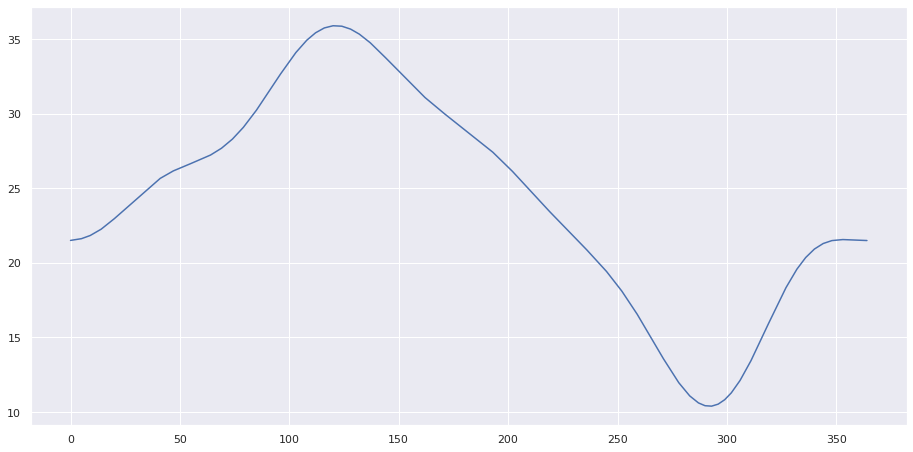

In [46]:
# Some papers suggest association between temperatures and virus spread
# https://repositum.tuwien.at/bitstream/20.500.12708/17056/1/Prager%20Lukas%20-%202021%20-%20Examining%20Austrian%20COVID-19%20Data%20in%20the%20Context%20of%20Linear...pdf#%5B%7B%22num%22%3A1106%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C72%2C628.0339966%2Cnull%5D
# https://www.sciencedirect.com/science/article/pii/S0048969720379213
# https://www.sciencedirect.com/science/article/pii/S1201971220302848

url = 'https://www.wien.gv.at/gogv/l9ogdwetter'
with open('./data/wiengv/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())
            
aut_weather= pd.read_csv("./data/wiengv/l9ogdwetter", sep=';', index_col = 0, header = 1)
aut_weather[aut_weather.columns[5:29]] = aut_weather[aut_weather.columns[5:29]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[782:]) #which rows to select for data since march 1 2020
print(aut_weather.columns)
X_w = aut_weather[aut_weather.columns[6]].iloc[782:782+12].to_numpy()
plt.plot(X_w)
plt.show()
X_w = signal.resample(X_w, aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])
plt.plot(X_w)
plt.show()

#avg over last 3 yrs
#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-12:782-12+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-24:782-24+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w= X_w/3

#plt.plot(X_w)
#plt.show()

## Regression analysis of variables

In [47]:
# Remove Colinear Variables
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
# https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = []
        for ix in range(X.iloc[:, variables].shape[1]):
            try:
                vif_ix = variance_inflation_factor(X.iloc[:, variables].values, ix)
                vif.append(vif_ix)
            except:
                vif.append(thresh+1.0)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [48]:
# Regression analysis
# Goodness of fit --> R2
# Significance F-Test overall, t-tests individual params.
# Evaluate OLS model on all features via F/t-testing
# Interpretation:
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# https://en.wikipedia.org/wiki/Regression_analysis

# Effective reproduction number
y = aut_reff['R_eff'].iloc[0:365].to_numpy()
y_lwr = aut_reff['R_eff_lwr'].iloc[0:365].to_numpy()
y_upr = aut_reff['R_eff_upr'].iloc[0:365].to_numpy()

# Pandemic
X_p = pd.DataFrame(aut_cov['Infected'].iloc[0:365], columns=['Infected'])
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Fatal'].iloc[0:365], columns=['Fatal'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Recovered'].iloc[0:365], columns=['Recovered'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Confirmed'].iloc[0:365], columns=['Confirmed'])), axis=1)

# Gov. measures from oxford tracker
X_g = aut_gov[69:(69+365)][aut_gov.columns[1:]].reset_index(drop=True) #10 march
      
# Weather data from Hohe Warte (ZAMG unfortunately has a paywall...)
X_w = aut_weather.iloc[782:][aut_weather.columns[5:28]]
X_w = signal.resample(X_w, y.shape[0])
X_w = pd.DataFrame(X_w, columns = aut_weather.columns[5:28])
X_w_c = calculate_vif_(X_w) # Remove multicolinear columns from weather data 

# Merge datasets analyse them togather
X_wgp = pd.concat((X_w, X_g, X_p), axis=1)
X_wg = pd.concat((X_w, X_g), axis=1)
X_gp = pd.concat((X_g, X_p), axis=1)
X_wp = pd.concat((X_w, X_p), axis=1)

X_w_cgp = pd.concat((X_w_c, X_g, X_p), axis=1)
X_w_cg = pd.concat((X_w_c, X_g), axis=1)
X_w_cp = pd.concat((X_w_c, X_p), axis=1)

dropping 'T' at index: 0
dropping 'T_MAX' at index: 0
dropping 'T_MIN' at index: 0
dropping 'MEAN_T_MAX' at index: 0
dropping 'MEAN_T_MIN' at index: 0
dropping 'NUM_FROST' at index: 0
dropping 'NUM_ICE' at index: 0
dropping 'NUM_SUMMER' at index: 0
dropping 'NUM_HEAT' at index: 0
dropping 'P' at index: 0
dropping 'P_MIN' at index: 1
dropping 'P_MAX' at index: 0
dropping 'REL_HUM_MAX' at index: 4
dropping 'REL_HUM' at index: 3
dropping 'WIND_VEL' at index: 4
dropping 'WIND_VEL_MAX' at index: 5
dropping 'NUM_PRECP_01' at index: 6
dropping 'REL_HUM_MIN' at index: 3
dropping 'SUN_H' at index: 0
dropping 'NUM_WIND_VEL60' at index: 2
Remaining variables:
Index(['NUM_CLEAR', 'NUM_CLOUD', 'PRECP_SUM'], dtype='object')


X_w, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     61.39
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           1.10e-78
Time:                        16:14:02   Log-Likelihood:                 72.932
No. Observations:                 365   AIC:                            -119.9
Df Residuals:                     352   BIC:                            -69.16
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                  0.0009      0.

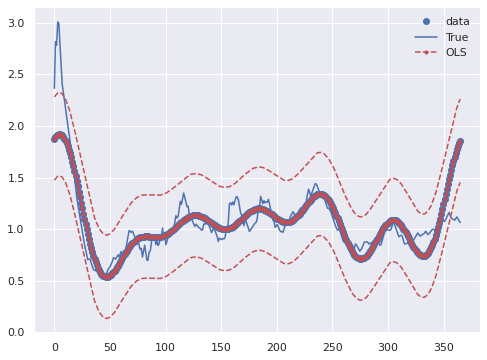

X_w, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     53.27
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           1.27e-71
Time:                        16:14:02   Log-Likelihood:                 30.984
No. Observations:                 365   AIC:                            -35.97
Df Residuals:                     352   BIC:                             14.73
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                  0.0018      0.002 

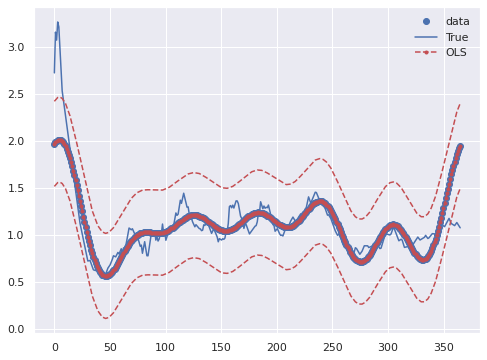

X_w, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     47.23
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           6.51e-66
Time:                        16:14:02   Log-Likelihood:                -10.241
No. Observations:                 365   AIC:                             46.48
Df Residuals:                     352   BIC:                             97.18
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                  0.0027      0.

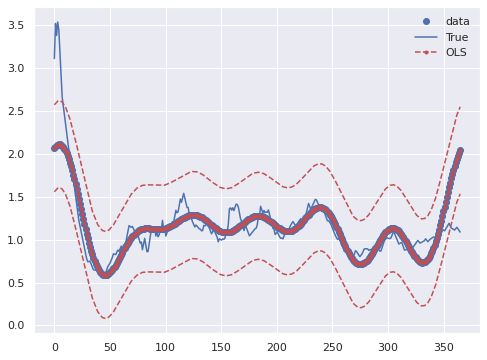

X_p, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.678
Method:                 Least Squares   F-statistic:                              257.5
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    2.01e-89
Time:                        16:14:02   Log-Likelihood:                         -349.71
No. Observations:                 365   AIC:                                      705.4
Df Residuals:                     362   BIC:                                      717.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

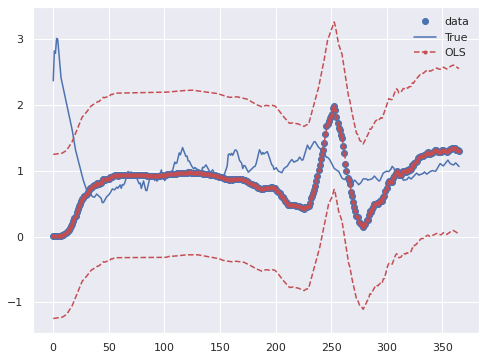

X_p, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.674
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              249.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    1.13e-87
Time:                        16:14:02   Log-Likelihood:                         -368.79
No. Observations:                 365   AIC:                                      743.6
Df Residuals:                     362   BIC:                                      755.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

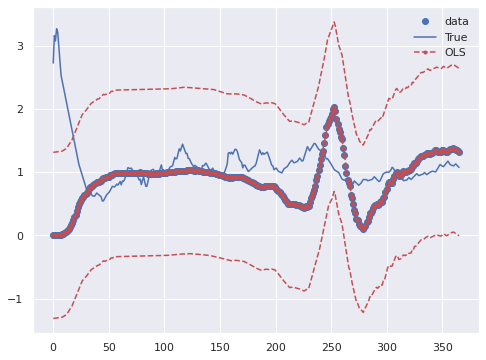

X_p, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              240.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    7.39e-86
Time:                        16:14:03   Log-Likelihood:                         -388.28
No. Observations:                 365   AIC:                                      782.6
Df Residuals:                     362   BIC:                                      794.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

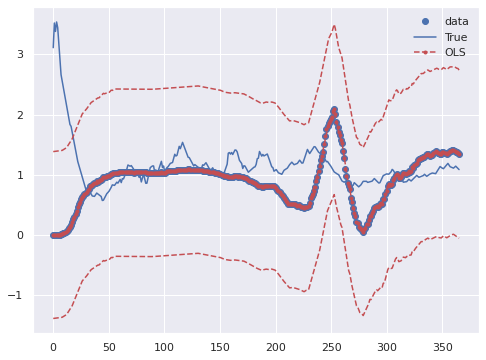

X_g, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     110.4
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          4.68e-107
Time:                        16:14:03   Log-Likelihood:                 138.90
No. Observations:                 365   AIC:                            -253.8
Df Residuals:                     353   BIC:                            -207.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

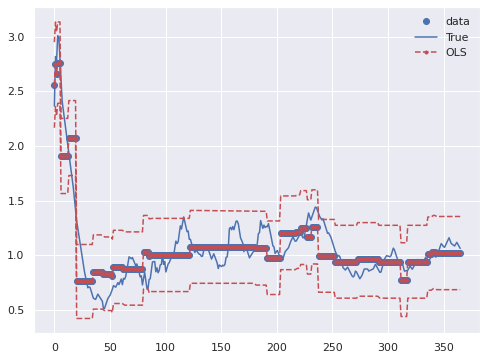

X_g, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     126.5
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.09e-115
Time:                        16:14:03   Log-Likelihood:                 133.68
No. Observations:                 365   AIC:                            -243.4
Df Residuals:                     353   BIC:                            -196.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

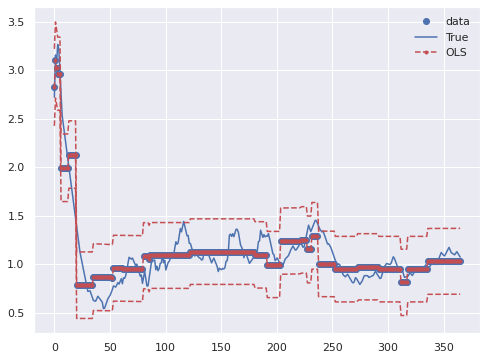

X_g, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     145.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.07e-123
Time:                        16:14:03   Log-Likelihood:                 126.57
No. Observations:                 365   AIC:                            -229.1
Df Residuals:                     353   BIC:                            -182.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

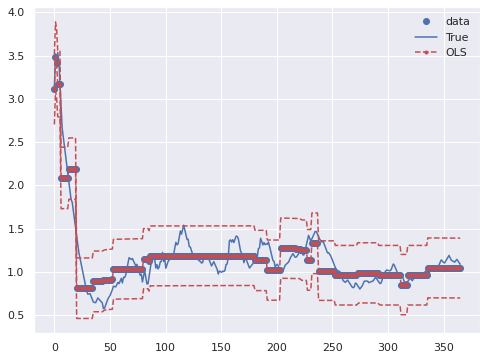

X_w_c, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              808.6
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   4.85e-160
Time:                        16:14:03   Log-Likelihood:                         -185.64
No. Observations:                 365   AIC:                                      377.3
Df Residuals:                     362   BIC:                                      389.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

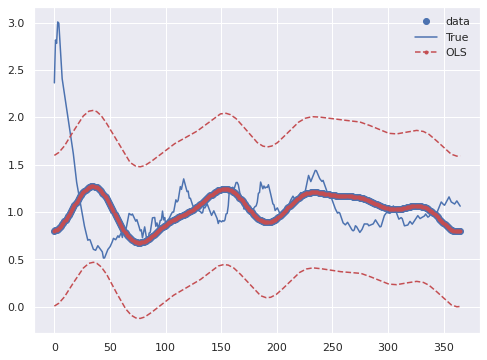

X_w_c, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                              746.5
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   1.31e-154
Time:                        16:14:03   Log-Likelihood:                         -213.27
No. Observations:                 365   AIC:                                      432.5
Df Residuals:                     362   BIC:                                      444.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

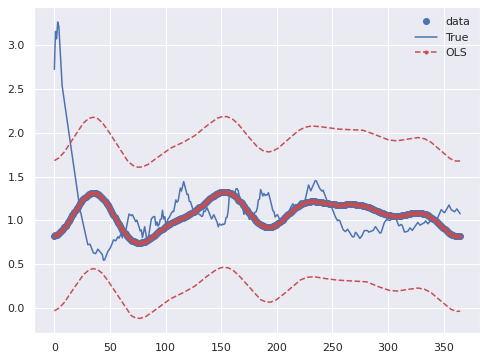

X_w_c, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              689.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   3.14e-149
Time:                        16:14:04   Log-Likelihood:                         -241.03
No. Observations:                 365   AIC:                                      488.1
Df Residuals:                     362   BIC:                                      499.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

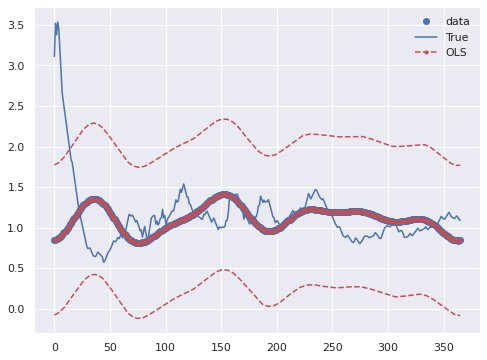

X_wgp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     326.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.60e-222
Time:                        16:14:04   Log-Likelihood:                 462.37
No. Observations:                 365   AIC:                            -870.7
Df Residuals:                     338   BIC:                            -765.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

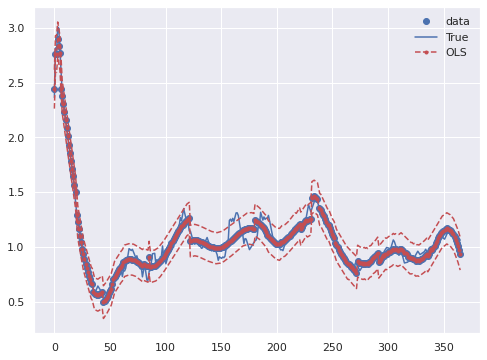

X_wgp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     335.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          6.02e-224
Time:                        16:14:04   Log-Likelihood:                 441.97
No. Observations:                 365   AIC:                            -829.9
Df Residuals:                     338   BIC:                            -724.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

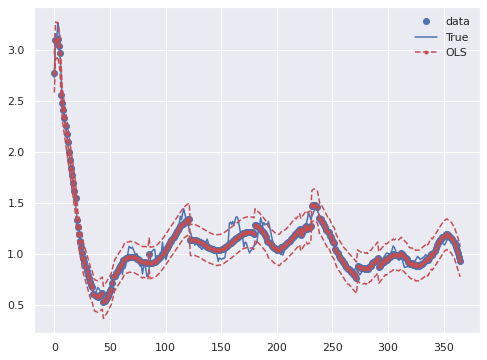

X_wgp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     344.1
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          7.65e-226
Time:                        16:14:04   Log-Likelihood:                 419.33
No. Observations:                 365   AIC:                            -784.7
Df Residuals:                     338   BIC:                            -679.4
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

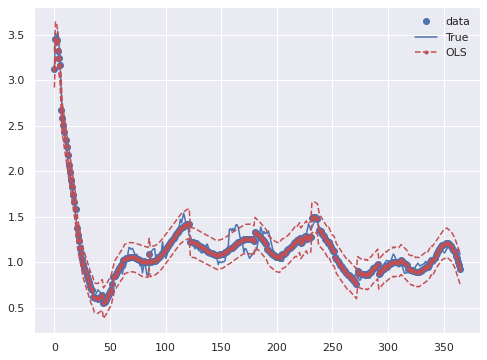

X_wg, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     256.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          9.17e-200
Time:                        16:14:04   Log-Likelihood:                 397.49
No. Observations:                 365   AIC:                            -747.0
Df Residuals:                     341   BIC:                            -653.4
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

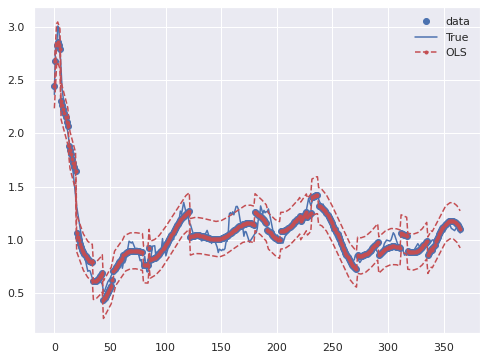

X_wg, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     261.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          6.01e-201
Time:                        16:14:05   Log-Likelihood:                 375.58
No. Observations:                 365   AIC:                            -703.2
Df Residuals:                     341   BIC:                            -609.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

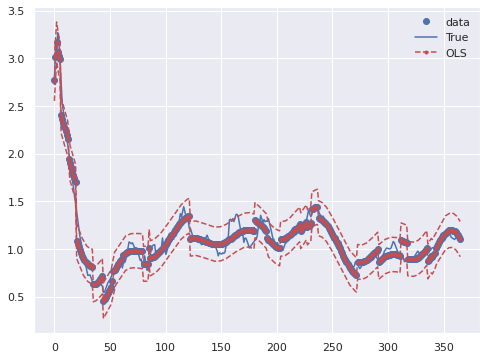

X_wg, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     267.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.64e-202
Time:                        16:14:05   Log-Likelihood:                 352.09
No. Observations:                 365   AIC:                            -656.2
Df Residuals:                     341   BIC:                            -562.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

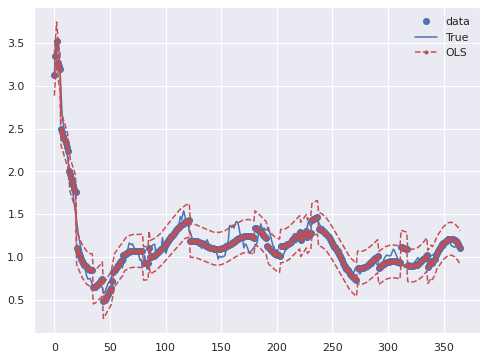

X_gp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     93.99
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          2.92e-109
Time:                        16:14:05   Log-Likelihood:                 151.61
No. Observations:                 365   AIC:                            -273.2
Df Residuals:                     350   BIC:                            -214.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

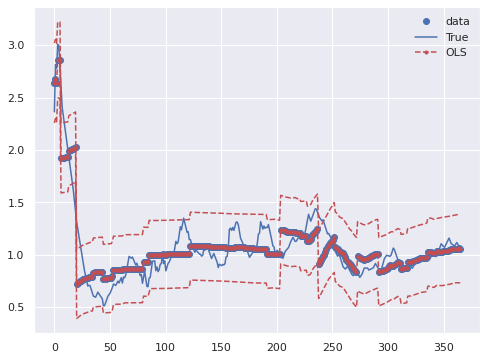

X_gp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          4.74e-117
Time:                        16:14:05   Log-Likelihood:                 145.64
No. Observations:                 365   AIC:                            -261.3
Df Residuals:                     350   BIC:                            -202.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

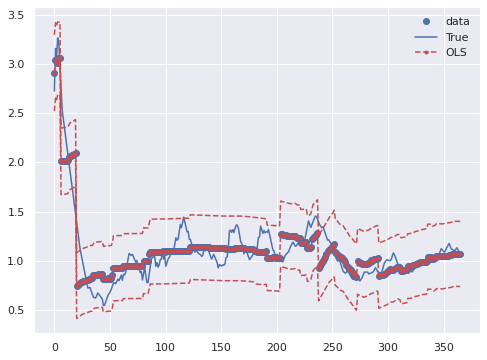

X_gp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     121.9
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.93e-125
Time:                        16:14:05   Log-Likelihood:                 137.82
No. Observations:                 365   AIC:                            -245.6
Df Residuals:                     350   BIC:                            -187.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

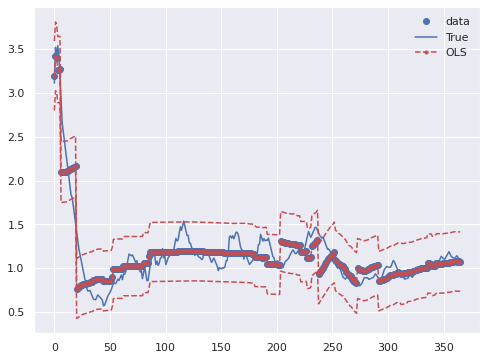

X_wp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     398.1
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          4.86e-209
Time:                        16:14:05   Log-Likelihood:                 395.49
No. Observations:                 365   AIC:                            -759.0
Df Residuals:                     349   BIC:                            -696.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0339      0

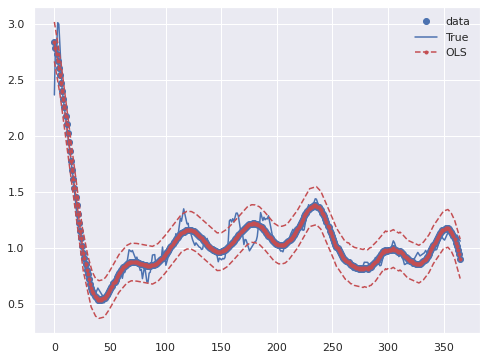

X_wp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     410.8
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          2.84e-211
Time:                        16:14:06   Log-Likelihood:                 376.05
No. Observations:                 365   AIC:                            -720.1
Df Residuals:                     349   BIC:                            -657.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0387      0.001

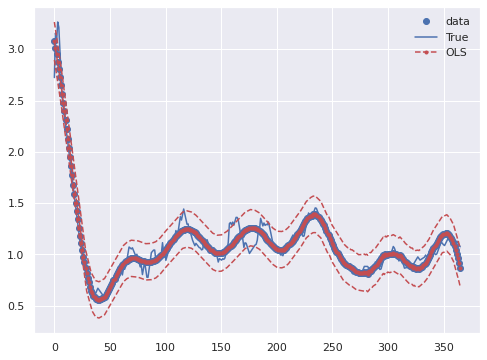

X_wp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     407.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          9.69e-211
Time:                        16:14:06   Log-Likelihood:                 347.40
No. Observations:                 365   AIC:                            -662.8
Df Residuals:                     349   BIC:                            -600.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0437      0

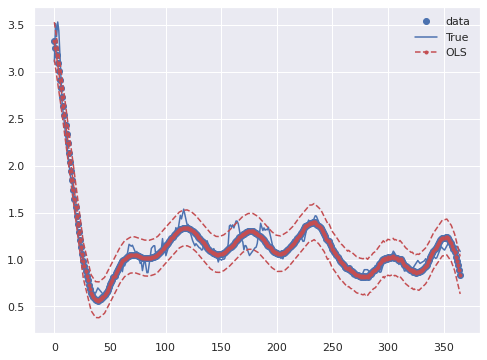

X_w_cgp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     123.5
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.10e-135
Time:                        16:14:06   Log-Likelihood:                 223.37
No. Observations:                 365   AIC:                            -410.7
Df Residuals:                     347   BIC:                            -340.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

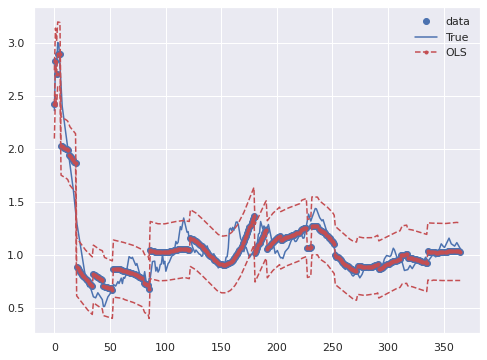

X_w_cgp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     134.6
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.23e-141
Time:                        16:14:06   Log-Likelihood:                 212.03
No. Observations:                 365   AIC:                            -388.1
Df Residuals:                     347   BIC:                            -317.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

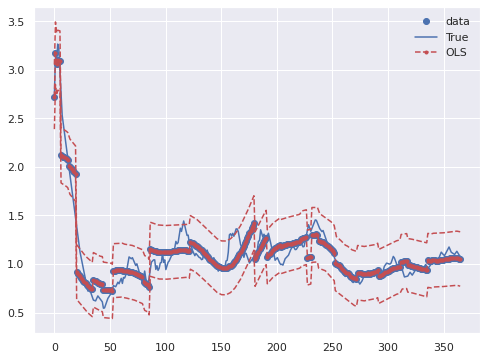

X_w_cgp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     147.3
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.94e-147
Time:                        16:14:06   Log-Likelihood:                 199.08
No. Observations:                 365   AIC:                            -362.2
Df Residuals:                     347   BIC:                            -292.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

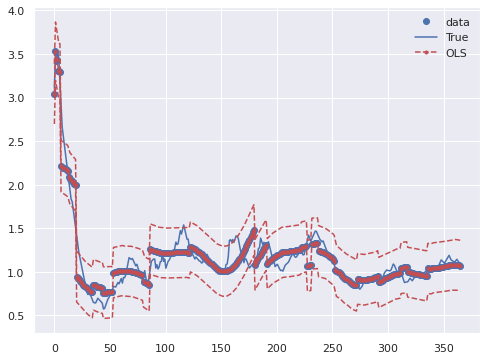

X_w_cg, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     144.4
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          6.59e-136
Time:                        16:14:07   Log-Likelihood:                 216.07
No. Observations:                 365   AIC:                            -402.1
Df Residuals:                     350   BIC:                            -343.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

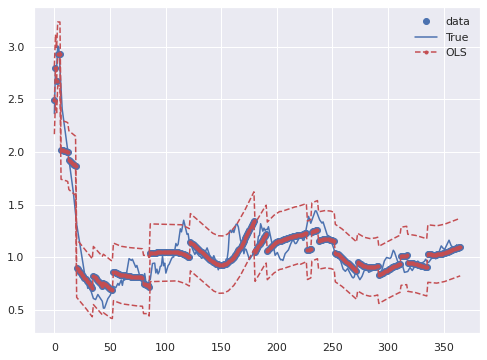

X_w_cg, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     157.8
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.21e-141
Time:                        16:14:07   Log-Likelihood:                 205.08
No. Observations:                 365   AIC:                            -380.2
Df Residuals:                     350   BIC:                            -321.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

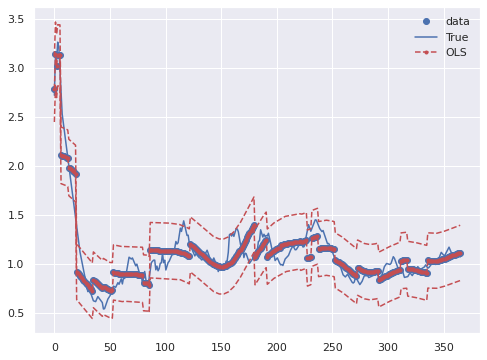

X_w_cg, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     173.1
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.00e-147
Time:                        16:14:07   Log-Likelihood:                 192.40
No. Observations:                 365   AIC:                            -354.8
Df Residuals:                     350   BIC:                            -296.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

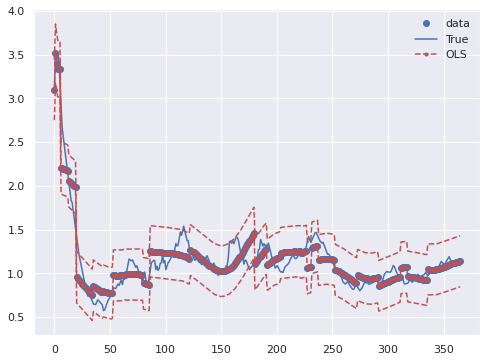

X_w_cp, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              456.9
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   1.08e-164
Time:                        16:14:07   Log-Likelihood:                         -164.72
No. Observations:                 365   AIC:                                      341.4
Df Residuals:                     359   BIC:                                      364.8
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

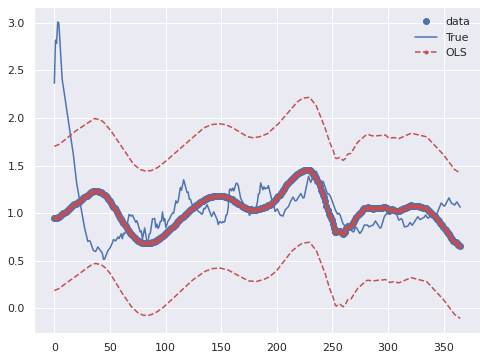

X_w_cp, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              420.4
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   5.48e-159
Time:                        16:14:07   Log-Likelihood:                         -193.11
No. Observations:                 365   AIC:                                      398.2
Df Residuals:                     359   BIC:                                      421.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

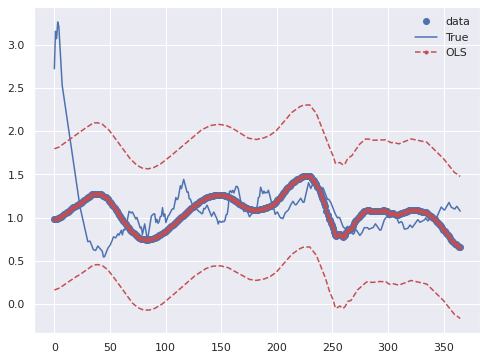

X_w_cp, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              386.8
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   2.44e-153
Time:                        16:14:07   Log-Likelihood:                         -221.62
No. Observations:                 365   AIC:                                      455.2
Df Residuals:                     359   BIC:                                      478.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

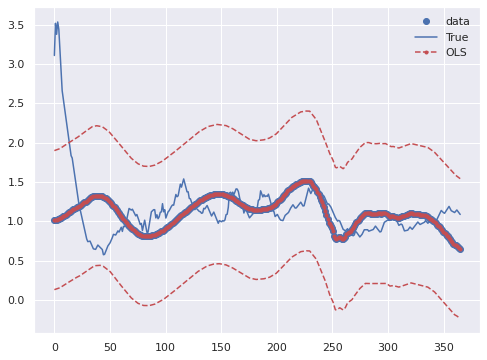

X_w, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     375.3
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          2.75e-192
Time:                        16:14:08   Log-Likelihood:                -2934.5
No. Observations:                 365   AIC:                             5895.
Df Residuals:                     352   BIC:                             5946.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T               -149.4542      7.

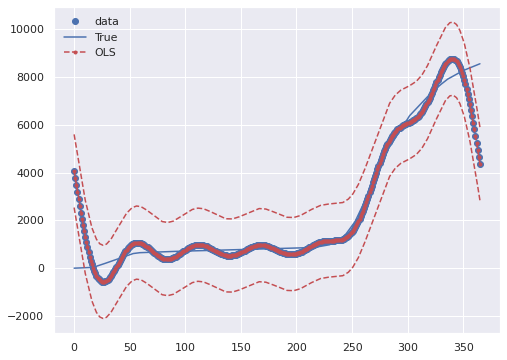

X_w, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     575.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          6.28e-223
Time:                        16:14:08   Log-Likelihood:                -3590.5
No. Observations:                 365   AIC:                             7207.
Df Residuals:                     352   BIC:                             7258.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T               -385.0678     

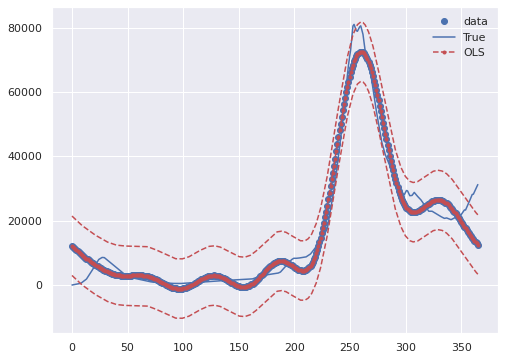

X_w, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     422.1
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.24e-200
Time:                        16:14:08   Log-Likelihood:                -4358.9
No. Observations:                 365   AIC:                             8744.
Df Residuals:                     352   BIC:                             8794.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T              -7411.4085    

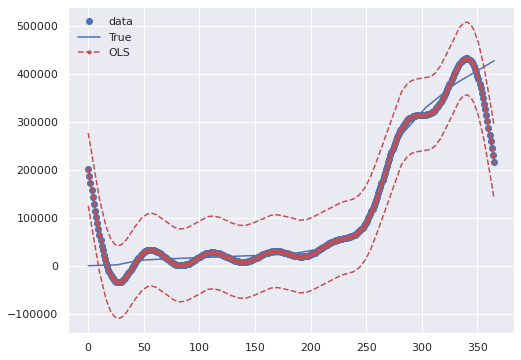

X_w, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     408.4
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          2.79e-198
Time:                        16:14:08   Log-Likelihood:                -4398.5
No. Observations:                 365   AIC:                             8823.
Df Residuals:                     352   BIC:                             8874.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T              -7945.9305    

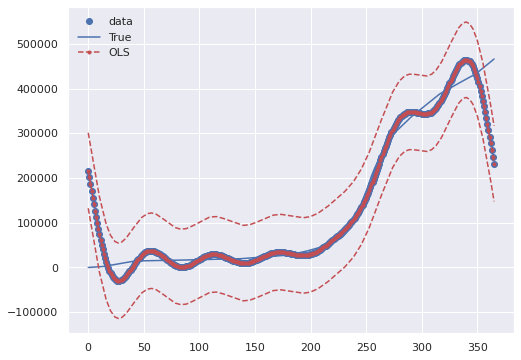

X_g, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     75.87
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           5.49e-86
Time:                        16:14:09   Log-Likelihood:                -3192.0
No. Observations:                 365   AIC:                             6408.
Df Residuals:                     353   BIC:                             6455.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

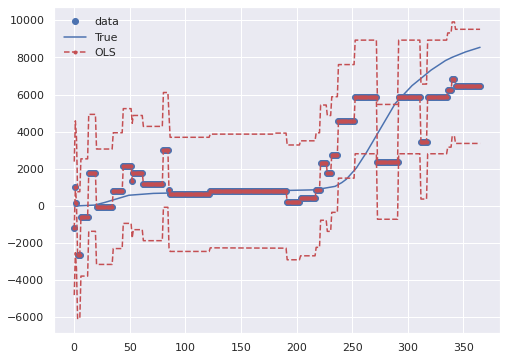

X_g, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     65.16
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           4.58e-78
Time:                        16:14:09   Log-Likelihood:                -3940.3
No. Observations:                 365   AIC:                             7905.
Df Residuals:                     353   BIC:                             7951.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

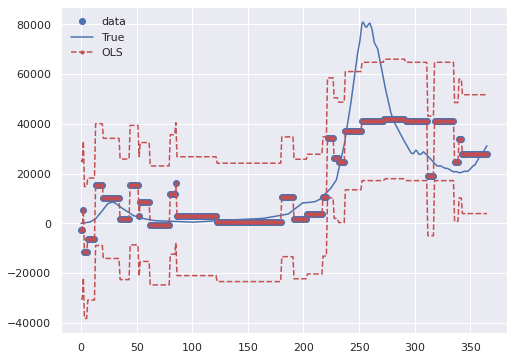

X_g, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     86.52
Date:                Sat, 17 Apr 2021   Prob (F-statistic):           4.03e-93
Time:                        16:14:09   Log-Likelihood:                -4619.2
No. Observations:                 365   AIC:                             9262.
Df Residuals:                     353   BIC:                             9309.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

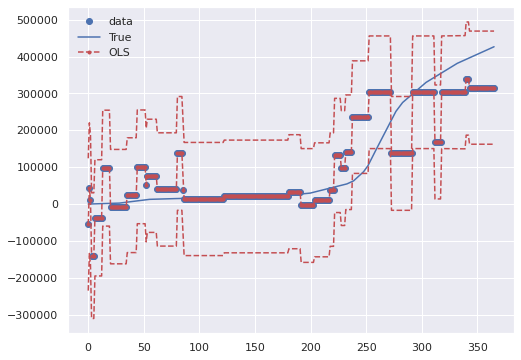

X_g, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     118.3
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.63e-111
Time:                        16:14:10   Log-Likelihood:                -4609.9
No. Observations:                 365   AIC:                             9244.
Df Residuals:                     353   BIC:                             9291.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

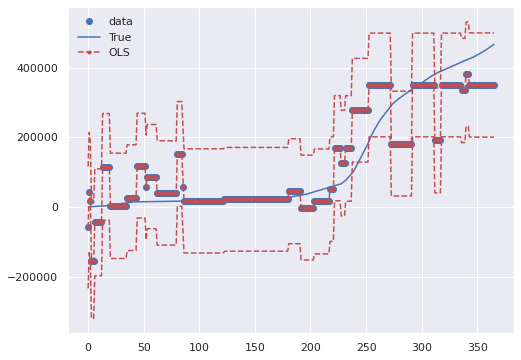

X_w_c, Fatal
                                 OLS Regression Results                                
Dep. Variable:                  Fatal   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              106.9
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    1.44e-49
Time:                        16:14:10   Log-Likelihood:                         -3398.8
No. Observations:                 365   AIC:                                      6804.
Df Residuals:                     362   BIC:                                      6815.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

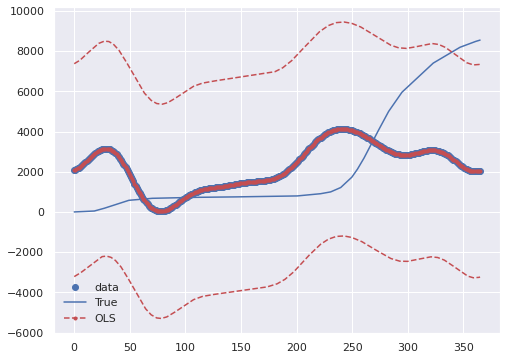

X_w_c, Infected
                                 OLS Regression Results                                
Dep. Variable:               Infected   R-squared (uncentered):                   0.788
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              447.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   2.38e-121
Time:                        16:14:10   Log-Likelihood:                         -3949.8
No. Observations:                 365   AIC:                                      7906.
Df Residuals:                     362   BIC:                                      7917.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

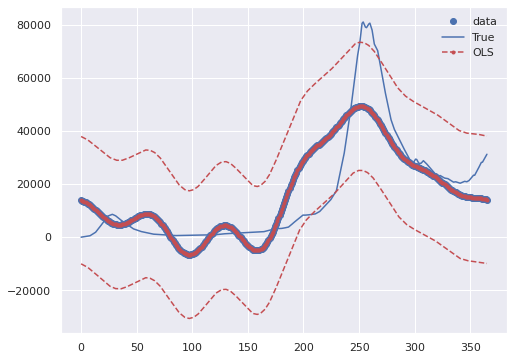

X_w_c, Recovered
                                 OLS Regression Results                                
Dep. Variable:              Recovered   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.461
Method:                 Least Squares   F-statistic:                              105.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    5.63e-49
Time:                        16:14:10   Log-Likelihood:                         -4830.7
No. Observations:                 365   AIC:                                      9667.
Df Residuals:                     362   BIC:                                      9679.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

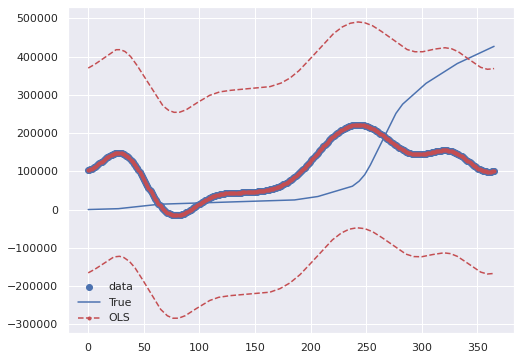

X_w_c, Confirmed
                                 OLS Regression Results                                
Dep. Variable:              Confirmed   R-squared (uncentered):                   0.526
Model:                            OLS   Adj. R-squared (uncentered):              0.522
Method:                 Least Squares   F-statistic:                              133.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    2.72e-58
Time:                        16:14:10   Log-Likelihood:                         -4851.6
No. Observations:                 365   AIC:                                      9709.
Df Residuals:                     362   BIC:                                      9721.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

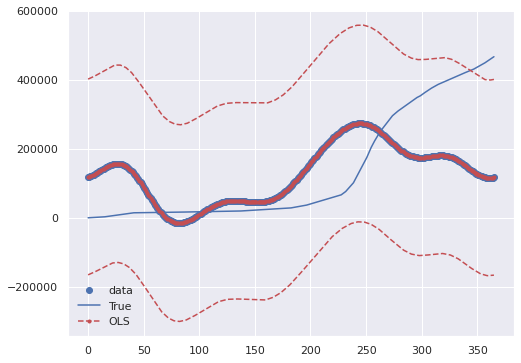

X_wg, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1635.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:10   Log-Likelihood:                -2553.4
No. Observations:                 365   AIC:                             5155.
Df Residuals:                     341   BIC:                             5248.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

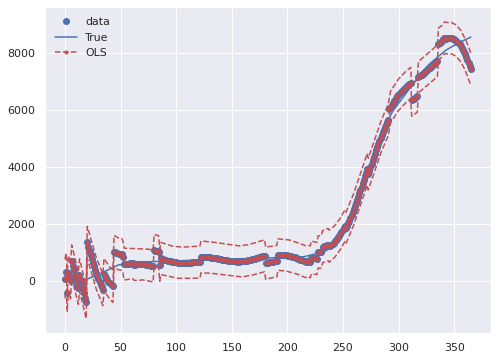

X_wg, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     966.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.08e-294
Time:                        16:14:11   Log-Likelihood:                -3377.6
No. Observations:                 365   AIC:                             6803.
Df Residuals:                     341   BIC:                             6897.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

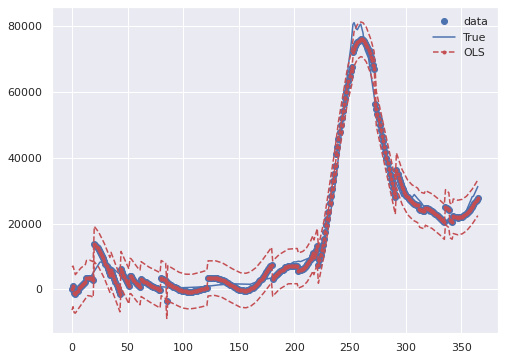

X_wg, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1669.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:11   Log-Likelihood:                -3994.1
No. Observations:                 365   AIC:                             8036.
Df Residuals:                     341   BIC:                             8130.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

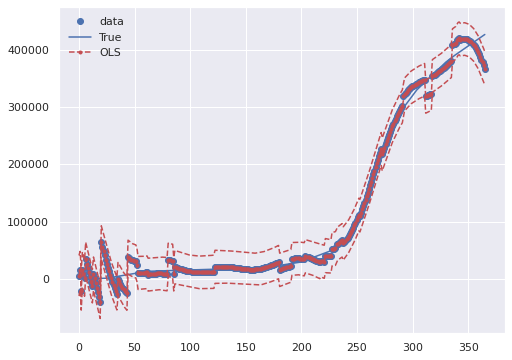

X_wg, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1634.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:11   Log-Likelihood:                -4031.9
No. Observations:                 365   AIC:                             8112.
Df Residuals:                     341   BIC:                             8205.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

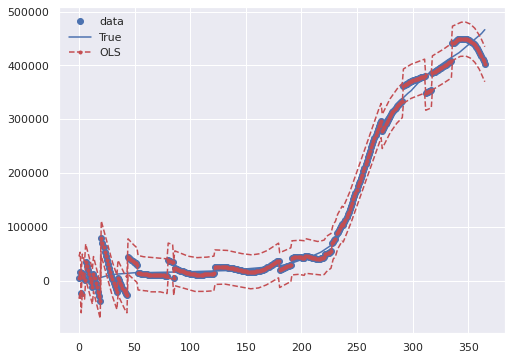

X_gp, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.171e+29
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:11   Log-Likelihood:                 8214.3
No. Observations:                 365   AIC:                        -1.640e+04
Df Residuals:                     350   BIC:                        -1.634e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

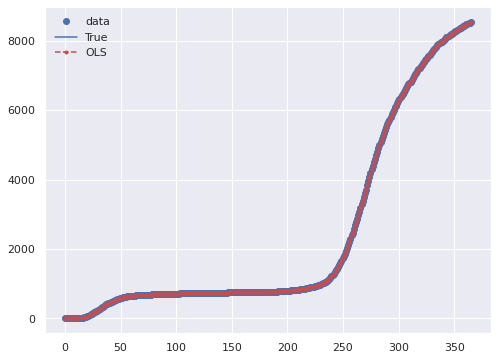

X_gp, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.111e+30
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:11   Log-Likelihood:                 8174.3
No. Observations:                 365   AIC:                        -1.632e+04
Df Residuals:                     350   BIC:                        -1.626e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

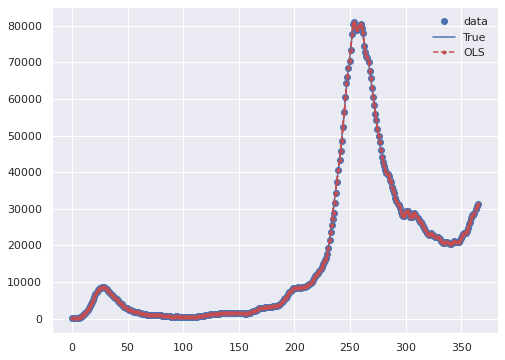

X_gp, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.941e+29
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:12   Log-Likelihood:                 7141.0
No. Observations:                 365   AIC:                        -1.425e+04
Df Residuals:                     350   BIC:                        -1.419e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

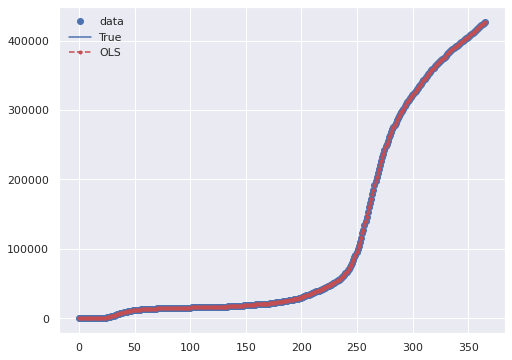

X_gp, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.977e+28
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:14:12   Log-Likelihood:                 6579.9
No. Observations:                 365   AIC:                        -1.313e+04
Df Residuals:                     350   BIC:                        -1.307e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

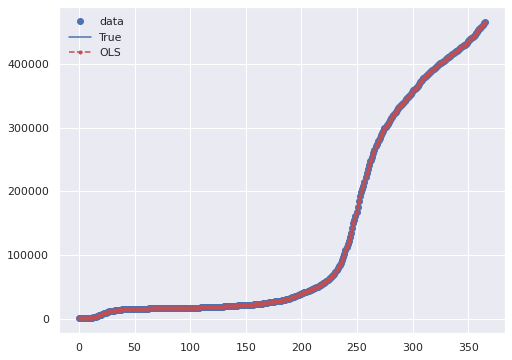

X_w_cg, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     123.4
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          6.27e-126
Time:                        16:14:12   Log-Likelihood:                -3088.3
No. Observations:                 365   AIC:                             6207.
Df Residuals:                     350   BIC:                             6265.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

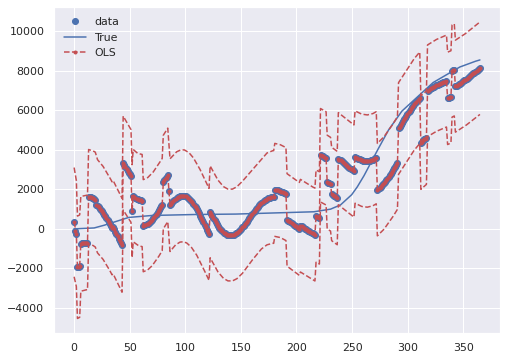

X_w_cg, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     274.8
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          4.21e-179
Time:                        16:14:12   Log-Likelihood:                -3689.3
No. Observations:                 365   AIC:                             7409.
Df Residuals:                     350   BIC:                             7467.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

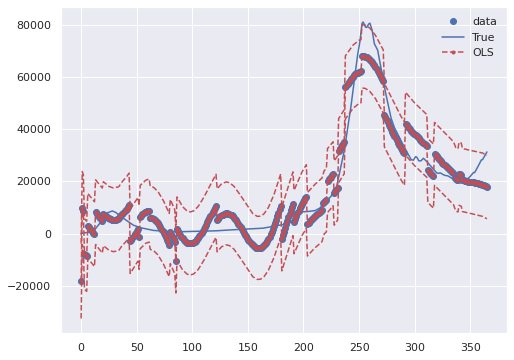

X_w_cg, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     121.2
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          8.27e-125
Time:                        16:14:12   Log-Likelihood:                -4535.4
No. Observations:                 365   AIC:                             9101.
Df Residuals:                     350   BIC:                             9159.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

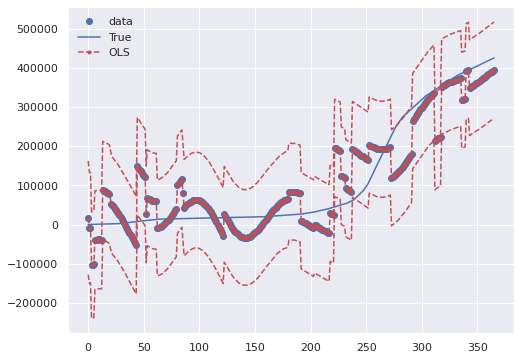

X_w_cg, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     139.1
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          1.70e-133
Time:                        16:14:13   Log-Likelihood:                -4548.4
No. Observations:                 365   AIC:                             9127.
Df Residuals:                     350   BIC:                             9185.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

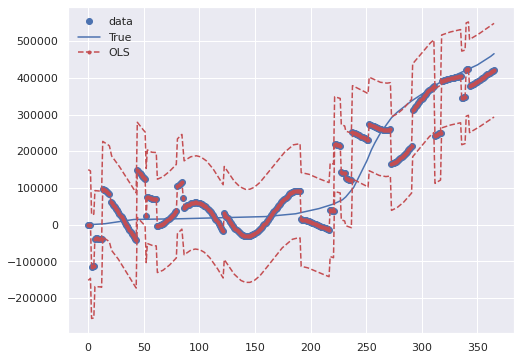

In [49]:
# Analyse all datsets seperately w.r.t Reproduction
x = np.linspace(0, 365, 365)
dependent = {'R_lwr': y_lwr, 'R': y, 'R_upr': y_upr}
independent = {'X_w': X_w, 'X_p': X_p, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wgp' : X_wgp, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_wp' : X_wp, 'X_w_cgp' : X_w_cgp,
               'X_w_cg' : X_w_cg, 'X_w_cp': X_w_cp}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
        
# ...w.r.t pandemic curve
dependent = {'Fatal': X_p['Fatal'], 'Infected': X_p['Infected'], 
             'Recovered': X_p['Recovered'], 'Confirmed' : X_p['Confirmed']}
independent = {'X_w': X_w, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_w_cg' : X_w_cg}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()

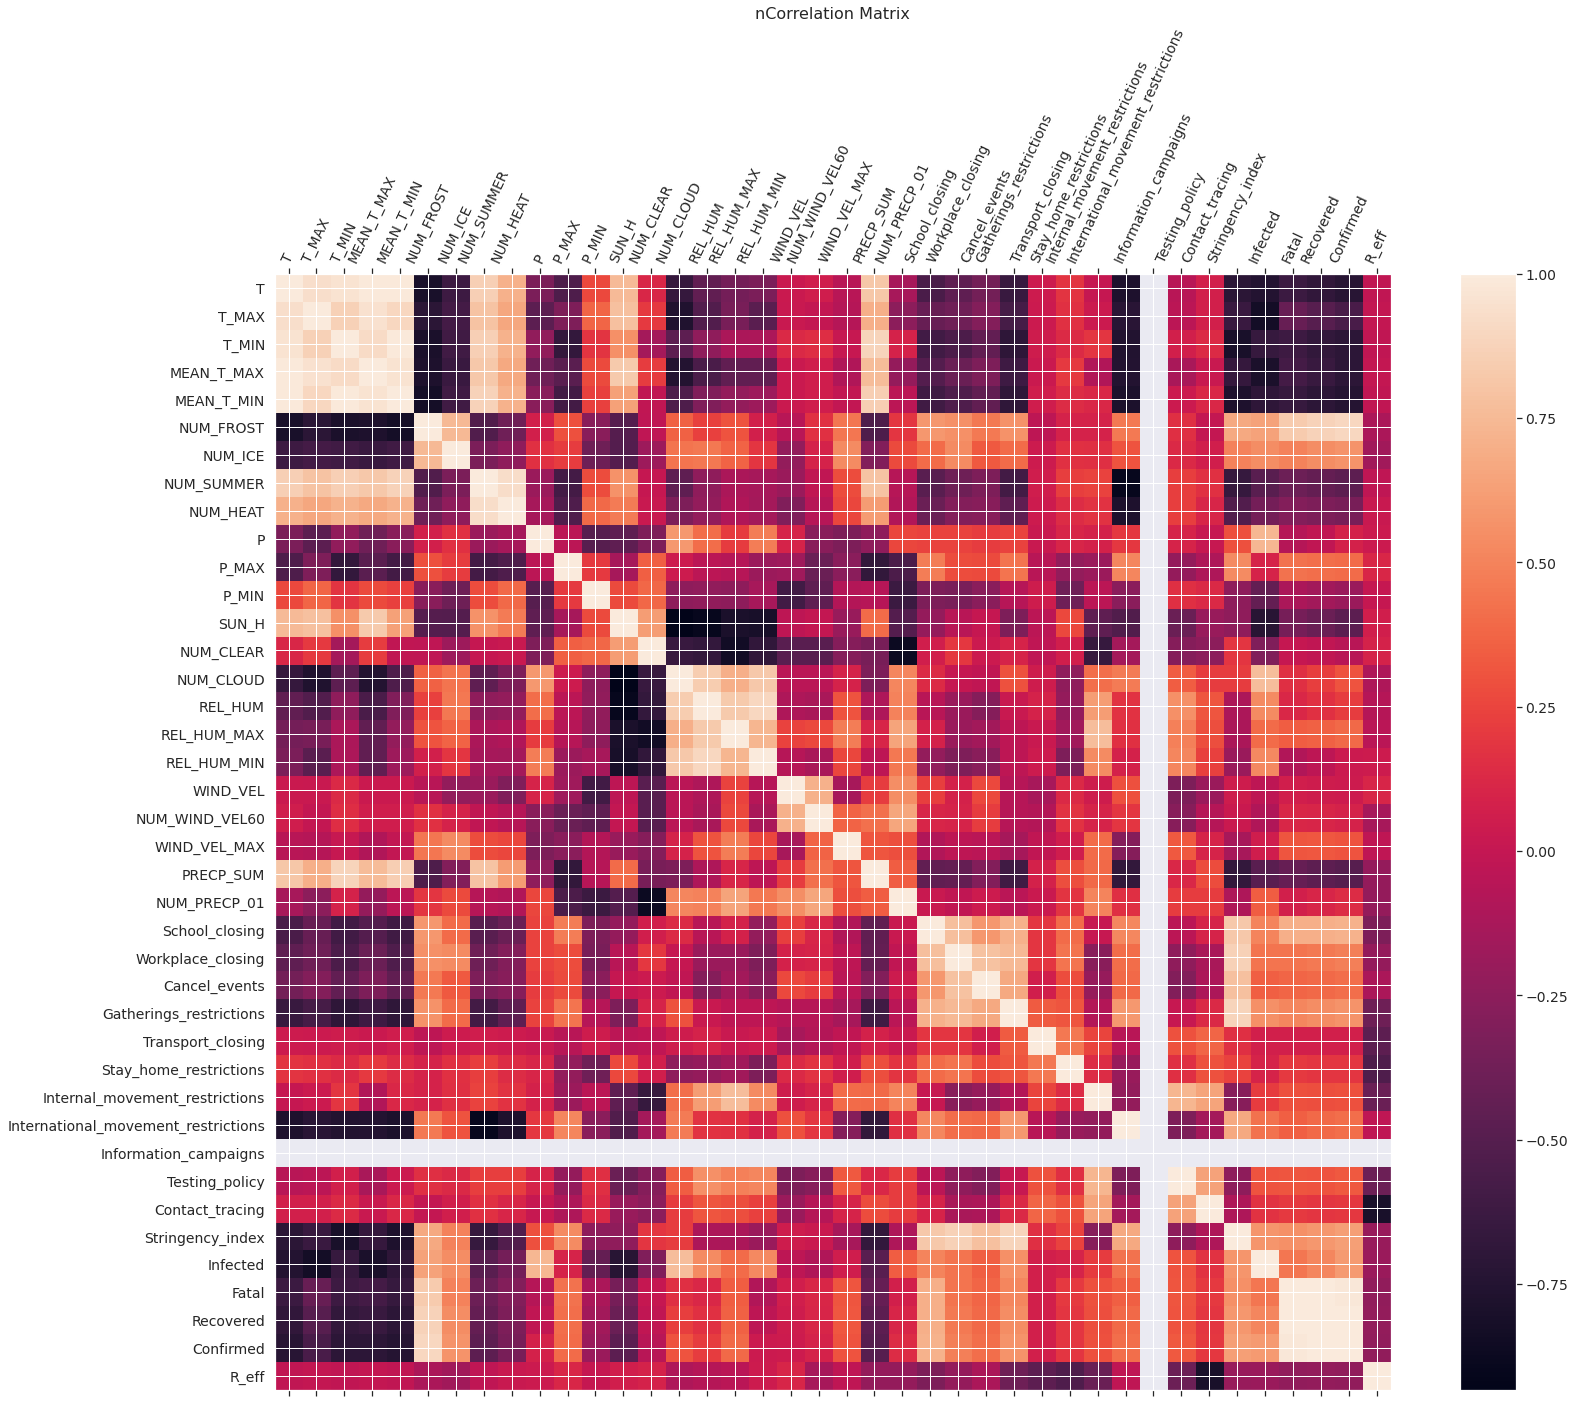

In [50]:
# Explore X, y datasets visually
Xy = pd.concat((X_wgp, pd.DataFrame(y, columns=['R_eff'])), axis=1)
Xy.reset_index(drop=True, inplace=True)

f = plt.figure(figsize=(25, 20))
plt.matshow(Xy.corr(), fignum=f.number)
plt.xticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('nCorrelation Matrix', fontsize=16);
plt.show()

## Based on above insights, build a model for R_eff


Selected k Reg. Features: ['NUM_FROST', 'NUM_ICE', 'P_MAX', 'SUN_H', 'NUM_CLEAR', 'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MIN', 'WIND_VEL', 'NUM_WIND_VEL60', 'PRECP_SUM', 'NUM_PRECP_01']
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              593.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   1.37e-225
Time:                        16:14:14   Log-Likelihood:                         -16.206
No. Observations:                 365   AIC:                                      56.41
Df Residuals:                     353   BIC:                                      103.2
Df Model:                          12                                                  
Covariance Type:           

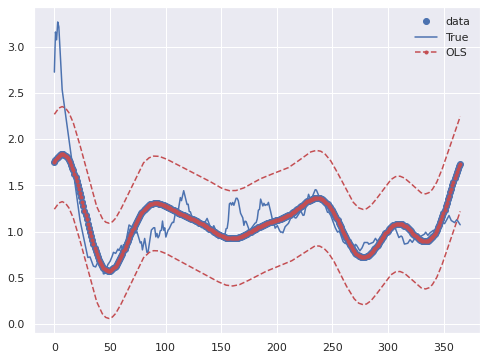

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     335.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.70e-243
Time:                        16:14:14   Log-Likelihood:                 563.12
No. Observations:                 365   AIC:                            -1028.
Df Residuals:                     316   BIC:                            -837.1
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
NU

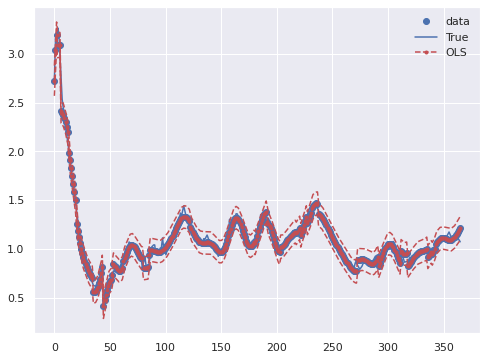

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              3192.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:14:14   Log-Likelihood:                          527.41
No. Observations:                 365   AIC:                                     -970.8
Df Residuals:                     323   BIC:                                     -807.0
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

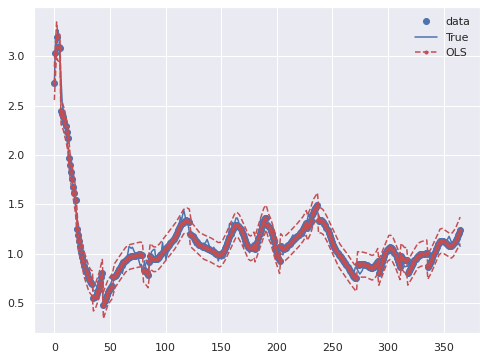

In [51]:
# Find best weather features
select_k = 12
#mutual_info_regression, f_regression
selector = SelectKBest(score_func=f_regression, k=select_k)
scaler = MinMaxScaler()
X_w = pd.DataFrame(scaler.fit_transform(X_w), columns=X_w.columns)
X_best = selector.fit_transform(X_w, y)
mask = selector.get_support() #list of booleans
features = [] # The list of your K best features
for bool, feature in zip(mask, X_w.columns):
    if bool:
        features.append(feature)
print('\nSelected k Reg. Features:', features)
X_w_best = X_w[features]

mod = sm.OLS(y, X_w_best)
res = mod.fit()
print(res.summary())

x = np.linspace(0,365,365)

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X_w_best)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()

# Try to build a good regressor
X = X_w_best#calculate_vif_(X_w_best, 5)

# Feature Engineering
# https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
import scipy.stats as st
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
for col in X.columns:
    X["{}_log+1".format(col)] = (X[col]+1).transform(np.log) # Log transform
    X["{}_conv".format(col)] = np.convolve(X[col], kern1d, 'same') # Convolution
    X["{}_pow2".format(col)] = X[col]*X[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g = pd.DataFrame(scaler.fit_transform(X_g), columns=X_g.columns)
X = pd.concat((X, X_g), axis=1)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()



# Remove statistically insignificant (p 0.05) features, they could break the model
insignificant = ['Stringency_index', 
                 'Information_campaigns', 
                 'REL_HUM', 
                 'SUN_H_conv', 
                 'NUM_WIND_VEL60_log+1',
                 'NUM_ICE_conv',
                 'NUM_CLEAR_log+1',
                 'NUM_PRECP_01_log+1',
                 'P_MAX',
                 'NUM_WIND_VEL60_conv',
                 'REL_HUM_MIN_log+1',
                 'REL_HUM_conv',
                 'NUM_CLOUD',
                 'NUM_PRECP_01_conv',
                 'PRECP_SUM',
                 'PRECP_SUM_conv',
                 'NUM_FROST',
                 'P_MAX_conv'
                ]


X = X.drop(columns=insignificant)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_const_cols = X.columns[X.nunique() <= 1]
#for col in X.columns:
#    if col not in X_const_cols:
        #X[col] = X[col]*X[col]+1
        #X[col], _, = boxcox(X[col], lmbda=None, alpha=None)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()


mod_lwr = sm.OLS(y_lwr, X)
res_lwr = mod.fit()
#print('\n Selected Featres OLS for R_eff_lwr')
#print(res_lwr.summary())

mod = sm.OLS(y_upr, X)
res_upr = mod.fit()
#print('\n Selected Featres OLS for R_eff_upr')
#print(res_upr.summary())


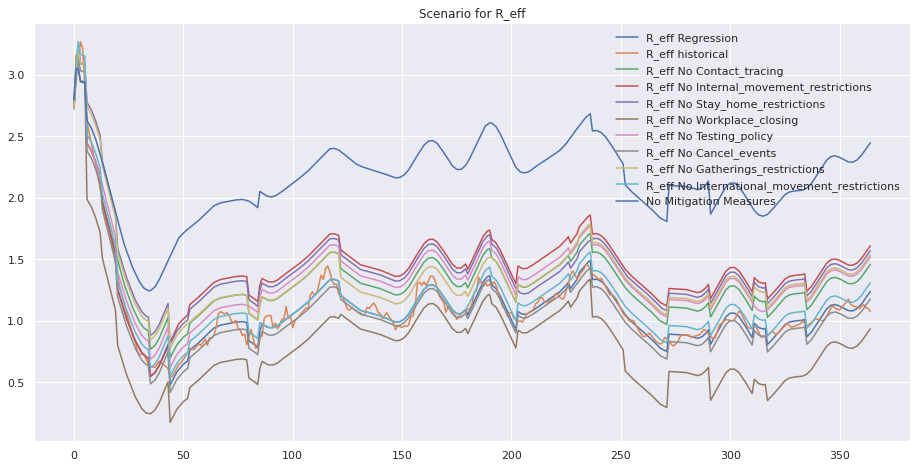

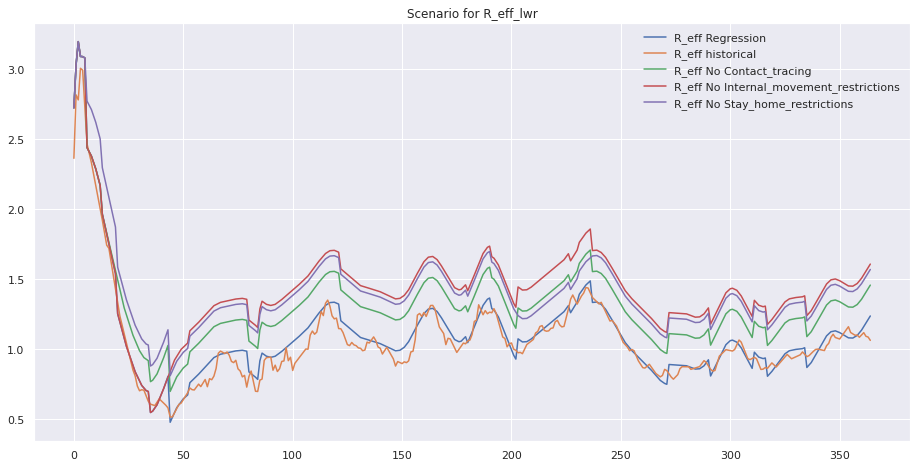

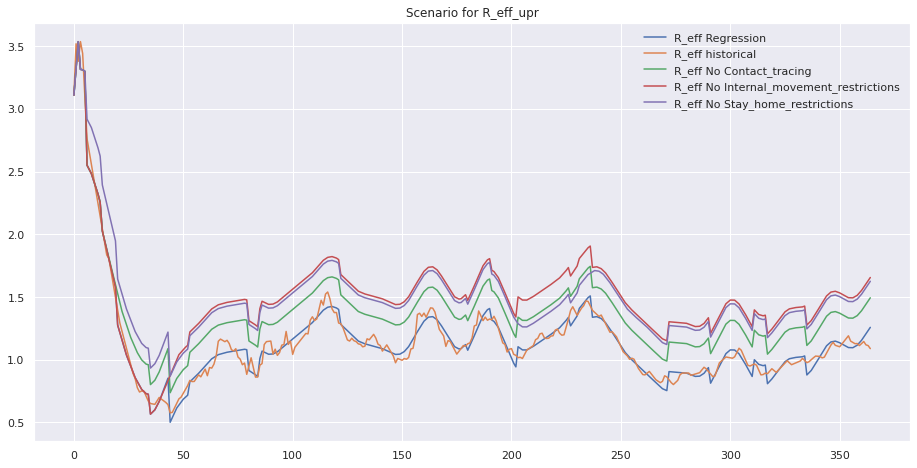

In [52]:
# Still some multicolinearity but we need some restriction still in the dataset
# Let's test the model an see how it behaves:
#plt.plot(res.predict(X), label ='R_eff Regression')
#plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.title('Scenario for R_eff')
#plt.legend()
#plt.show()

plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()

plt.plot(res_lwr.predict(X), label ='R_eff Regression')
plt.plot(y_lwr, label = 'R_eff historical')
plt.plot(res_lwr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_lwr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_lwr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_lwr')
plt.legend()
plt.show()

plt.plot(res_upr.predict(X), label ='R_eff Regression')
plt.plot(y_upr, label = 'R_eff historical')
plt.plot(res_upr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_upr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_upr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_upr')
plt.legend()
plt.show()

0.9597309376270917


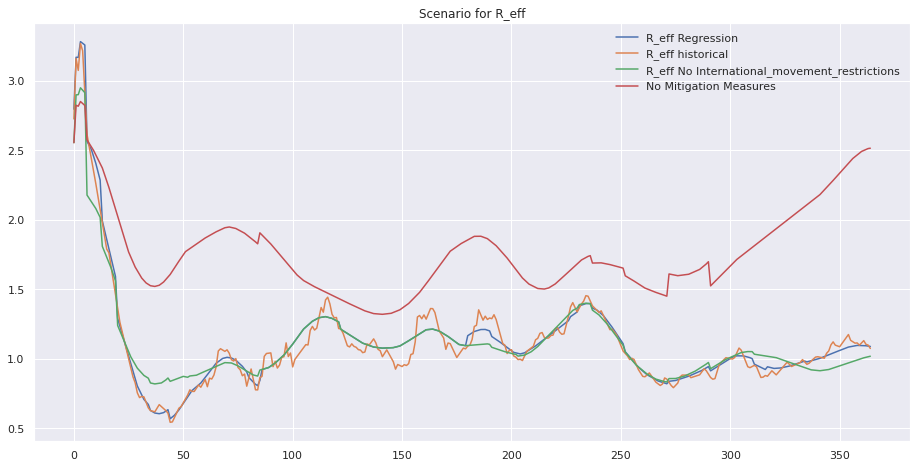

0.9641407136588281
0.9572018034965825


In [53]:
# Give MLP Regressor a shot
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, random_state=1, test_size=0.3)

res = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1,
                   batch_size=10, warm_start= False
                  ).fit(X_train, y_train)
print(res.score(X_test, y_test))



plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
#plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
#plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
#plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()


#Lets look at lowr and upr bounds
X_train, X_test, y_train, y_test = train_test_split(X, y_lwr, random_state=1, test_size=0.3)
res_lwr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_lwr.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y_upr, random_state=1, test_size=0.3)
res_upr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_upr.score(X_test, y_test))

## SEIR-FV Model with Reinfection, ICUs and Hospitalizations Capacities, Adjusted for Age-Groups and Virus Reproduction depending on Meteorological Effects and Government Policies
Improved SIR Model taking into account weather and effective reproduction number based on various mitigation scenarios

In [156]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682 # Mar 27 2020
VAC_full_effect = 0.95 #Probability of any vaccine preventing contraction, cannot infect others
VAC_once_effect = 0.95 #Probability of any vaccine preventing death, can infect others

def deriv(t, y, N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R_eff):
    y_i = ()
    ICUs_required = 0
    HOSPs_requried = 0
    N_sum = sum(N)
    numvars = 7
    
    #Compute ICUs and Hospital Beds required
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        ICUs_required+=I*epsilon[i//numvars]*rho[i//numvars]
        HOSPs_requried+=I*epsilon[i//numvars]*rho[i//numvars]
    HOSPs_requried - ICUs_required
    
    # Hospital beds or ICUs full
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)

    #Time until Exposed move to Infected
    alpha = 1.0/3.0 # https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile
    
    # Inter group contractions
    beta = [R_eff[int(round(t))]*(gamma[i]+delta_i) for i, delta_i in enumerate(delta)]
    
    # Intra group contractions
    beta_avg = sum(beta)/len(beta)
    beta = [0.5*(beta_avg+b) for b in beta]

    
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        
        # Single and Double Vaccinations
        dV1dt = S * vac_once_per_day/N_sum*VAC_once_effect if t >= t_vac_once_start else 0
        dV2dt = S * vac_full_per_day/N_sum*VAC_full_effect if t >= t_vac_full_start else 0

        # Decrease in Suspectables
        dSdt = -beta[i//numvars] * S * I / N[i//numvars] - dV2dt if S >= 0 else +0.0
            
        # Probability that and individual of a group has been succesfully vaccinated once
        theta = V1/S 
        
        # Suspectable to Exposed minus Exposed to Infected
        dEdt = beta[i//numvars] * S * I / N[i//numvars] - alpha * E
        
        # Infected to Recovered
        dRdt = (1+theta)* I * gamma[i//numvars] * (1 - (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Infected to Fatalities
        dFdt = (1-theta)* I * delta[i//numvars] * (1 + (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Exposed to Infected minus Recovered + Fatalities
        dIdt = alpha * E - dRdt - dFdt
        
        # Reinfection after reocivering possible after 5-7 months: 
        # EXPERIMENTAL
        # https://www.cell.com/immunity/fulltext/S1074-7613(20)30445-3
        # How ist it with Vaccines?
        dSdt += (1.0/180.0)*R + (1.0/210.0)*V2
        dV2dt += -(1.0/210.0)*V2
        dV1dt += -(1.0/210.0)*V1
        dRdt += -(1.0/180.0)*R
        
        y_i += dSdt, dEdt, dIdt, dRdt, dFdt, dV1dt, dV2dt
    return y_i

from scipy.integrate import solve_ivp
def run_sim(N, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, t_vac_once_start, t_vac_full_start, R):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - E0- I0 - R0 - F0 - V20
        y0 += (S0, E0, I0, R0, F0, V10, V20)

    ret = solve_ivp(fun=deriv, t_span=(min(t), max(t)), y0=y0, t_eval=t, max_step=0.25,
                    method='RK23',
                    args=(N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R))
    return [*ret['y']]

## Hypothetical Scenarios for 2020-2021

8901063.999999998

SCENARIO END STATE: Historical R
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -6.20881716410319e-10
Suspectable: 7943014 to 8857473
Exposed: 0 to 13265
Infected: 0 to 70991
Fatalities: 0 to 64308
Recovered: 0 to 550719
Vaccinated Fully: 259201 to 287407
Vaccinated Once: 973539 to 1076689
Model evaluated w.r.t. historical data:
R2 0.2821650672122737
EV 0.5325692587550427
RMSE 3583955796.918718
RMSLE 1.274131592305135


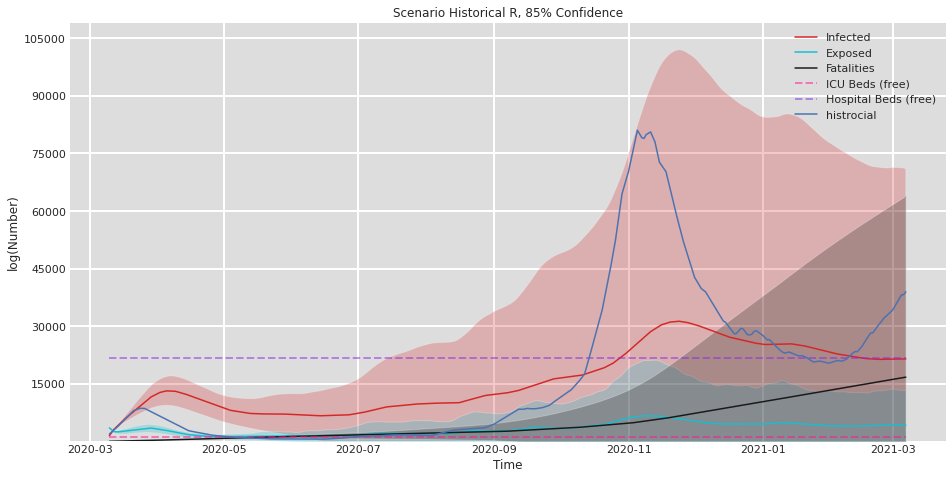

8901063.999999989

SCENARIO END STATE: Regression R
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -1.862645149230957e-09
Suspectable: 7674098 to 8992105
Exposed: 0 to 15599
Infected: 0 to 82580
Fatalities: 0 to 96819
Recovered: 0 to 782818
Vaccinated Fully: 250113 to 292066
Vaccinated Once: 939295 to 1094417
Model evaluated w.r.t. historical data:
R2 -0.8641953385040188
EV -0.009131834158648378
RMSE 2154577565.7181606
RMSLE 1.5310181384955286


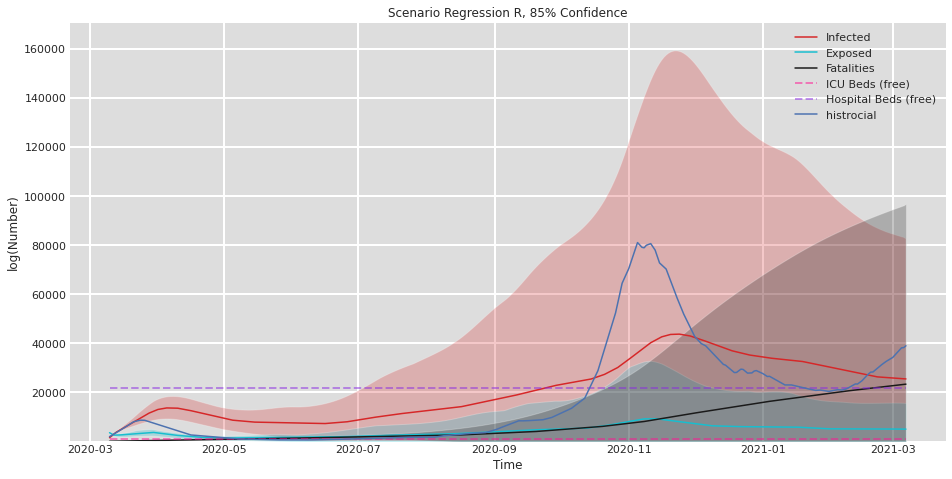

8901063.999999994

SCENARIO END STATE: No Events Canceled
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 6.20881716410319e-10
Suspectable: 7163890 to 9169109
Exposed: 0 to 29280
Infected: 0 to 137015
Fatalities: 0 to 123423
Recovered: 0 to 1212492
Vaccinated Fully: 234976 to 297739
Vaccinated Once: 884485 to 1115500


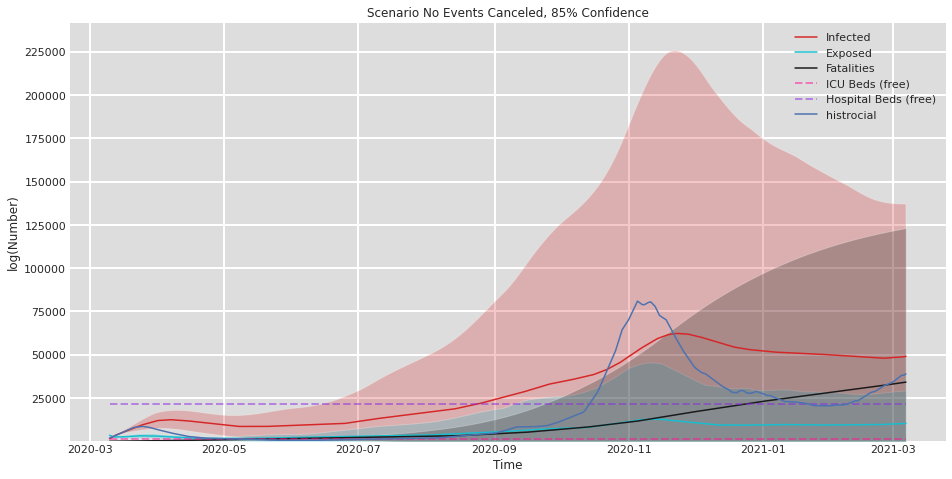

8901063.999999993

SCENARIO END STATE: No Contact Tracing
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -5.587935447692871e-09
Suspectable: 3914491 to 8938765
Exposed: 31391 to 71492
Infected: 123631 to 320079
Fatalities: 44640 to 171466
Recovered: 0 to 4374752
Vaccinated Fully: 123049 to 303142
Vaccinated Once: 458346 to 1150579


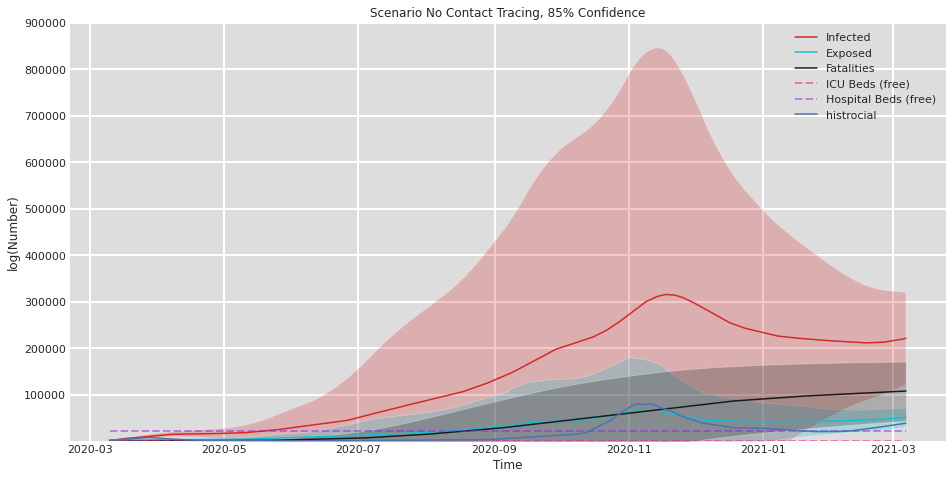

8901064.000000002

SCENARIO END STATE: No Internal Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -1.241763432820638e-09
Suspectable: 6708173 to 9169134
Exposed: 0 to 46250
Infected: 0 to 201279
Fatalities: 0 to 138079
Recovered: 0 to 1586675
Vaccinated Fully: 222175 to 298343
Vaccinated Once: 838853 to 1118080


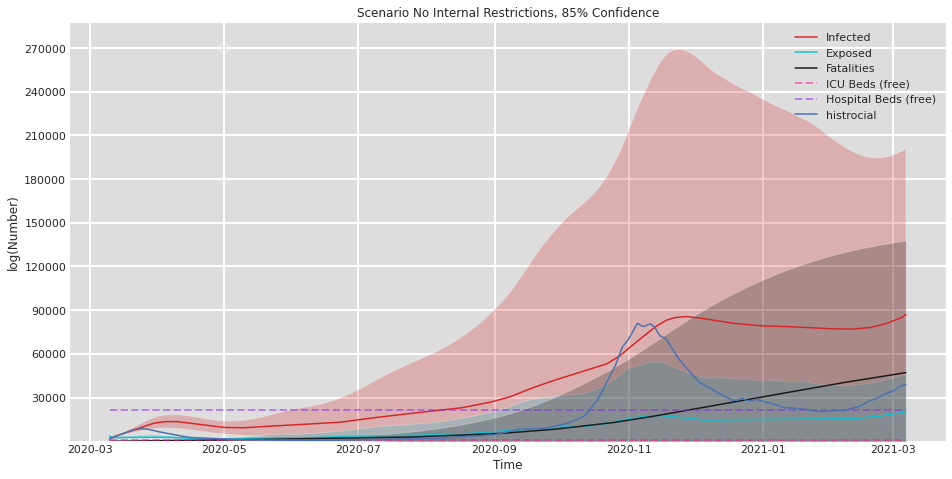

8901063.999999998

SCENARIO END STATE: No Workplace Closing
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 7706191 to 8941404
Exposed: 0 to 17988
Infected: 0 to 92925
Fatalities: 0 to 87212
Recovered: 0 to 745424
Vaccinated Fully: 251841 to 290169
Vaccinated Once: 946770 to 1086998


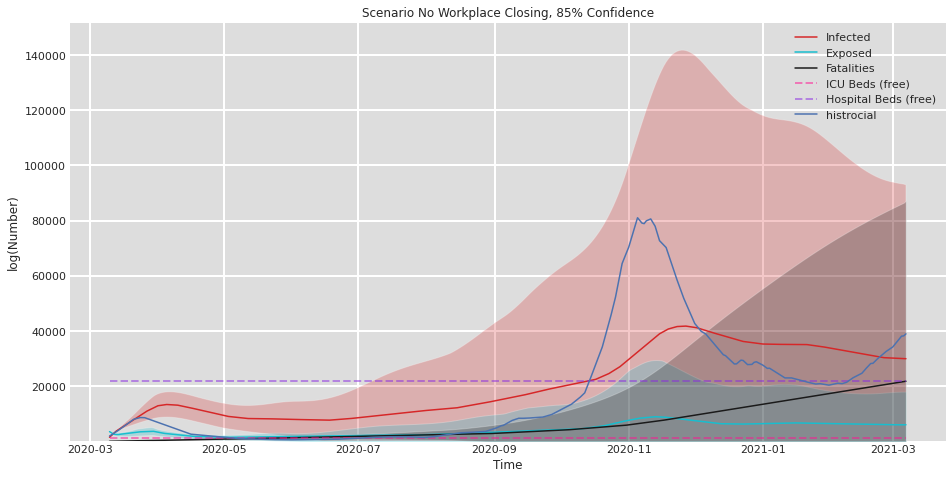

8901064.0

SCENARIO END STATE: No Stay Home Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -6.20881716410319e-10
Suspectable: 6734776 to 9219247
Exposed: 0 to 36609
Infected: 0 to 162762
Fatalities: 0 to 163337
Recovered: 0 to 1584163
Vaccinated Fully: 221085 to 299776
Vaccinated Once: 832488 to 1123715


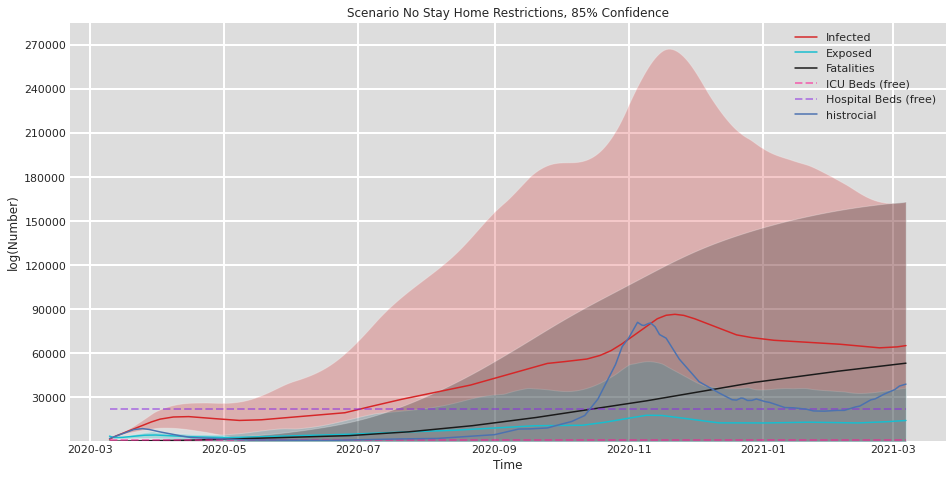

8901063.999999998

SCENARIO END STATE: No Gathering Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 1.241763432820638e-09
Suspectable: 6387918 to 9157977
Exposed: 0 to 48369
Infected: 0 to 204489
Fatalities: 0 to 158628
Recovered: 0 to 1910035
Vaccinated Fully: 210568 to 298235
Vaccinated Once: 793204 to 1118739


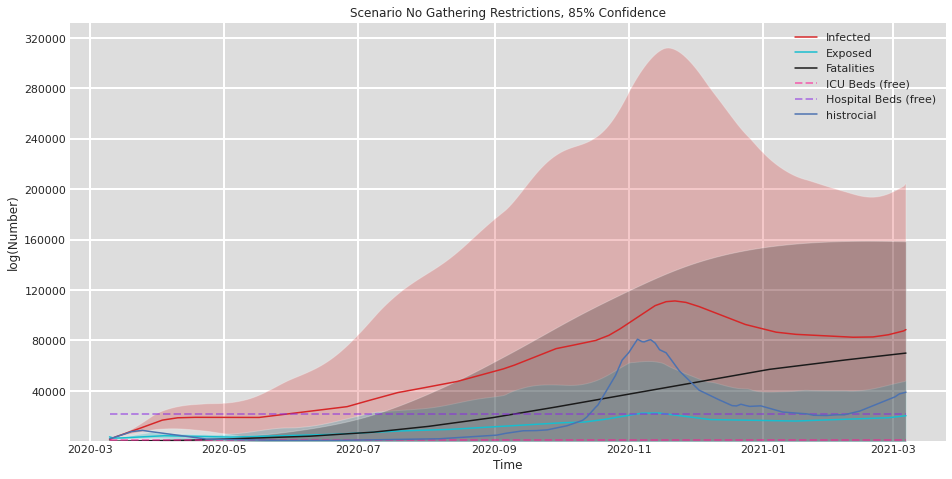

8901064.0

SCENARIO END STATE: No School Closings
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 6110257 to 9244267
Exposed: 0 to 49415
Infected: 0 to 212308
Fatalities: 0 to 173647
Recovered: 0 to 2162145
Vaccinated Fully: 201306 to 301800
Vaccinated Once: 758810 to 1132723


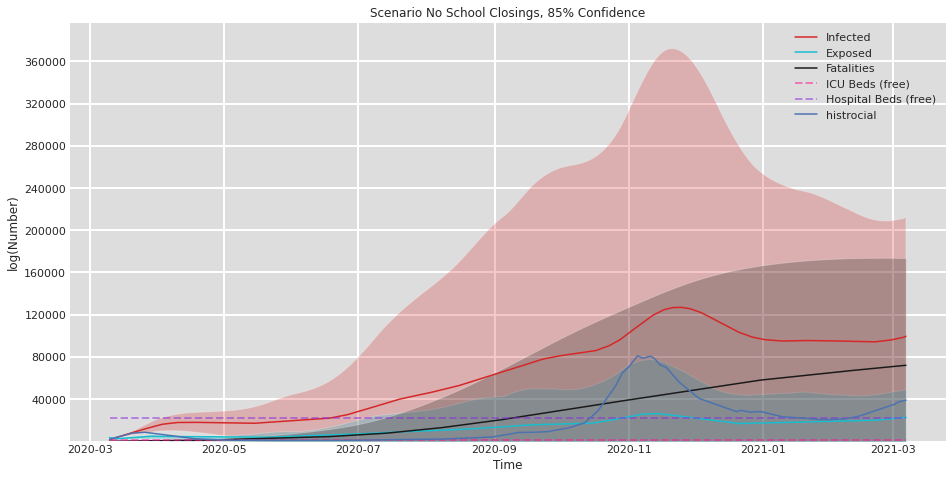

8901064.0

SCENARIO END STATE: No Mitigation Measures
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 1.862645149230957e-09
Suspectable: 3706950 to 4716134
Exposed: 8111 to 181523
Infected: 78353 to 628104
Fatalities: 267892 to 315675
Recovered: 3647225 to 3971172
Vaccinated Fully: 136699 to 144286
Vaccinated Once: 508768 to 538845


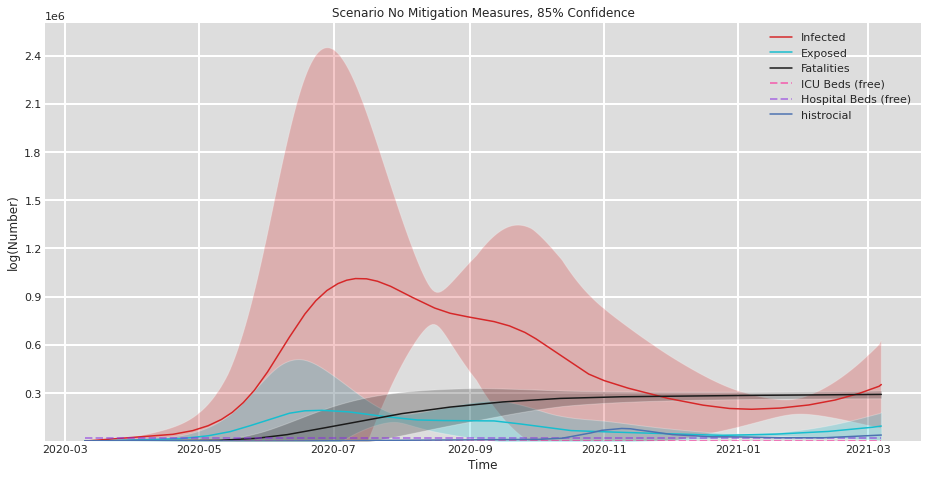

8901063.999999981

SCENARIO END STATE: Zero-Covid Measures
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 8582914 to 8632925
Exposed: 0 to 616
Infected: 0 to 2756
Fatalities: 0 to 1891
Recovered: 0 to 33903
Vaccinated Fully: 278983 to 280575
Vaccinated Once: 1045984 to 1051898


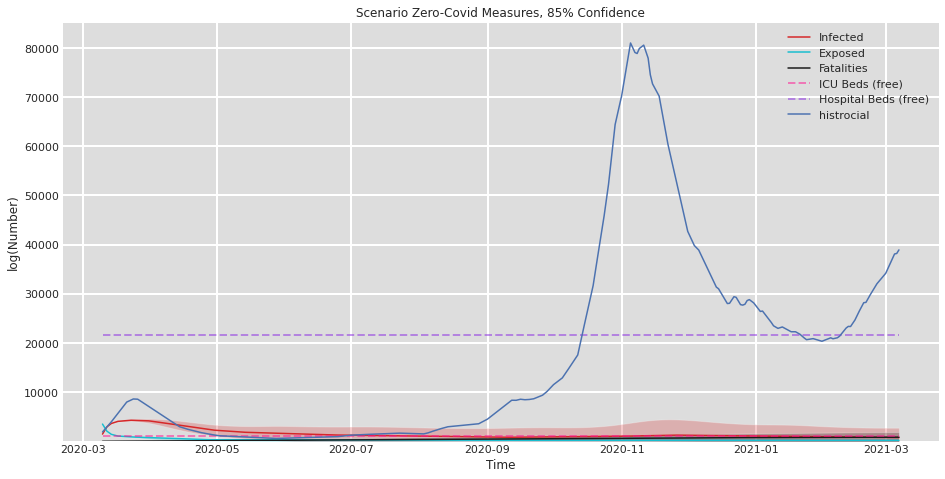

In [158]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_full_start = 317 #Full vaccinations 15.01.2021
t_vac_once_start = 298 #Full vaccinations 27.12.2020
duration = 363#len(aut_cov['Infected'].to_numpy())

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }


scenarios = {
    'Historical R' : [y_lwr, y, y_upr, scores],
    'Regression R' : [res_lwr.predict(X), res.predict(X), res_upr.predict(X), scores],
    'No Events Canceled' :[res_lwr.predict(X.assign(Cancel_events = 0)),
                           res.predict(X.assign(Cancel_events = 0)),
                           res_upr.predict(X.assign(Cancel_events = 0)), None],
    'No Contact Tracing' :[res_lwr.predict(X.assign(Contact_tracing = 0)),
                           res.predict(X.assign(Contact_tracing = 0)),
                           res_upr.predict(X.assign(Contact_tracing = 0)), None],
    'No Internal Restrictions' :[res_lwr.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res_upr.predict(X.assign(Internal_movement_restrictions = 0)), None],
    'No Workplace Closing' :[res_lwr.predict(X.assign(Workplace_closing = 0)),
                                      res.predict(X.assign(Workplace_closing = 0)),
                                      res_upr.predict(X.assign(Workplace_closing = 0)), None],
    'No Stay Home Restrictions' :[res_lwr.predict(X.assign(Stay_home_restrictions = 0)),
                                  res.predict(X.assign(Stay_home_restrictions = 0)),
                                  res_upr.predict(X.assign(Stay_home_restrictions = 0)), None],
    'No Gathering Restrictions' :[res_lwr.predict(X.assign(Gatherings_restrictions = 0)),
                                  res.predict(X.assign(Gatherings_restrictions = 0)),
                                  res_upr.predict(X.assign(Gatherings_restrictions = 0)), None],
    'No School Closings': [res_lwr.predict(X.assign(School_closing = 0)),
                                  res.predict(X.assign(School_closing = 0)),
                                  res_upr.predict(X.assign(School_closing = 0)), None],
    'No Mitigation Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res_upr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)), None],
    'Zero-Covid Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res_upr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)), None]
        
}

for scenario in scenarios:
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[4]*2.4 ,infected[4] , recovered[4], fatal[4], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
    
    for i in range(0,len(ret_upr),7):
        
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
        
    z = 2*1.05*1.75 #90% Confidence * Reproduction Unvertainity  * SIR Model uncertainty
    S_std = np.array([S_lwr, S, S_upr]).std(axis=0)*z
    S_mean = np.array([S_lwr, S, S_upr]).mean(axis=0)
    I_std = np.array([I_lwr, I, I_upr]).std(axis=0)*z
    I_mean = np.array([I_lwr, I, I_upr]).mean(axis=0)
    E_std = np.array([E_lwr, E, E_upr]).std(axis=0)*z
    E_mean = np.array([E_lwr, E, E_upr]).mean(axis=0)
    R_std = np.array([R_lwr, R, R_upr]).std(axis=0)*z
    R_mean = np.array([R_lwr, R, R_upr]).mean(axis=0)
    F_std = np.array([F_lwr, F, F_upr]).std(axis=0)*z
    F_mean = np.array([F_lwr, F, F_upr]).mean(axis=0)
    V2_std = np.array([V2_lwr, V2, V2_upr]).std(axis=0)*z
    V2_mean = np.array([V2_lwr, V2, V2_upr]).mean(axis=0)
    V1_std = np.array([V1_lwr, V1, V1_upr]).std(axis=0)*z
    V1_mean = np.array([V1_lwr, V1, V1_upr]).mean(axis=0)
    
    
    IE_std = np.array([
        list(map(add, I_lwr, E_lwr)),
        list( map(add, I, E)),
        list( map(add, I_upr, E_upr))
        ]).std(axis=0)*z
    IE_mean = np.array([
        list(map(add, I_lwr, E_lwr)),
        list( map(add, I, E)),
        list( map(add, I_upr, E_upr))
        ]).mean(axis=0)

    print(F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1])
    print("\nSCENARIO END STATE: {}".format(scenario))
    print('Numerical Sanity check: S+E+I+R+F+V = N', 'Average Error:',
          ((F_lwr[-1]+R_lwr[-1]+S_lwr[-1]+I_lwr[-1]+V2_lwr[-1]+E_lwr[-1] - sum(pop_groups))+
           (F[-1]+R[-1]+S[-1]+I[-1]+V2[-1]+E[-1] - sum(pop_groups)) +
          (F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1] - sum(pop_groups)))/3)
    print('Suspectable:', int(max(S_mean[-1]-S_std[-1], 0)), 'to', int(S_mean[-1]+S_std[-1]))
    print('Exposed:', int(max(E_mean[-1]-E_std[-1], 0)), 'to', int(E_mean[-1]+E_std[-1]))
    print('Infected:', int(max(I_mean[-1]-I_std[-1], 0)), 'to', int(I_mean[-1]+I_std[-1]))
    print('Fatalities:', int(max(F_mean[-1]-F_std[-1], 0)), 'to', int(F_mean[-1]+F_std[-1]))
    print('Recovered:', int(max(R_mean[-1]-R_std[-1], 0)), 'to', int(R_mean[-1]+R_std[-1]))
    print('Vaccinated Fully:', int(max(V2_mean[-1]-V2_std[-1], 0)), 'to', int(V2_mean[-1]+V2_std[-1]))
    print('Vaccinated Once:', int(max(V1_mean[-1]-V1_std[-1], 0)), 'to', int(V1_mean[-1]+V1_std[-1]))
    
    if scoring is not None:
        print('Model evaluated w.r.t. historical data:')
        for scorer in scoring:
            val = 0

            mean = np.array([I, I_lwr, I_upr]).mean(axis=0)
            val += scoring[scorer](infected[5:5+duration], mean)

            mean = np.array([R, R_lwr, R_upr]).mean(axis=0)
            val += scoring[scorer](recovered[5:5+duration], mean)
            
            mean = np.array([F, F_lwr, F_upr]).mean(axis=0)
            val += scoring[scorer](fatal[5:5+duration], mean)
            print(scorer, val/3)
    
    
    # Alternative Uncertainity
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    #ax.fill_between(t, S_mean-S_std, S_mean+S_std, facecolor='tab:blue', alpha=0.25, interpolate=True)
    #ax.plot(t, S_mean, 'tab:blue', label='Suspectable')
    #ax.plot(t, infected[5:5+363], label='Hist')
    
    ax.fill_between(t, I_mean-I_std, I_mean+I_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, I_mean, 'tab:red', label='Infected')
    ax.fill_between(t, E_mean-E_std, E_mean+E_std, facecolor='tab:cyan', alpha=0.25, interpolate=True)
    ax.plot(t, E_mean, 'tab:cyan', label='Exposed')
    #ax.fill_between(t, R_mean-R_std, R_mean+R_std, facecolor='tab:green', alpha=0.25, interpolate=True)
    #ax.plot(t, R_mean, 'tab:green', label='Recovered')
    ax.fill_between(t, F_mean-F_std, F_mean+F_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, F_mean, 'k', label='Fatalities')
    #ax.fill_between(t, V1_mean-V1_std, V1_mean+V1_std, facecolor='tab:orange', alpha=0.25, interpolate=True)
    #ax.plot(t, V1_mean,'tab:orange', alpha=0.5, lw=2, label='Once Vaccinated')
    ax.plot(t, [ICUs_free]*len(F_lwr),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
    ax.plot(t, [HOSPs_free]*len(F_lwr), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
    ax.plot(t, infected[13:363+13], label= 'histrocial')
    ax.set_xlabel('Time')
    ax.set_ylabel('log(Number)')
    #ax.set_yscale('log')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title("Scenario {}, 85% Confidence".format(scenario))
    ax.plot()
    plt.show()

## Hypothetical Scenarios for 2020 to 2024

In [ ]:
# Make a simple statistical weather prediction neglecting global warming, etc 
import random
aut_weather[aut_weather.columns[5:28]] = aut_weather[aut_weather.columns[5:28]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[:782+12]) #which rows to select for data since march 1 2020
print(aut_weather.columns[5:28])
X_w_all = aut_weather[aut_weather.columns[5:28]].iloc[:782+12]#.to_numpy()

# Slow and ugly but does the job
X_w_all_agg = pd.DataFrame()
for col in X_w_all.columns:
    month_mean = []
    month_std = []
    for j in range(0,12,1):
        year = []
        for i in range(j+12*40, len(X_w_all[col]),12):
            year.append(X_w_all[col].iloc[i])
        month_mean.append(np.array(year).mean())
        month_std.append(np.array(year).std())
    X_w_all_agg["{}_mean".format(col)] = month_mean
    X_w_all_agg["{}_std".format(col)] = month_std

X_w_all_new_1 = pd.DataFrame()
X_w_all_new_2 = pd.DataFrame()
X_w_all_new_3 = pd.DataFrame()


for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    
'''
for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
'''    
X_w_hist = aut_weather[aut_weather.columns[5:28]].iloc[782:782+12]
X_w_1yr = pd.concat((X_w_hist, X_w_all_new_1)).reset_index(drop=True)
X_w_2yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2)).reset_index(drop=True)
X_w_3yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2, X_w_all_new_3)).reset_index(drop=True)

X_w_1yr = pd.DataFrame(
    signal.resample(X_w_1yr, np.linspace(0,365*2,365*2).shape[0]),
    columns = X_w_1yr.columns)
plt.plot(X_w_1yr['T'])
plt.show()

X_w_2yr = pd.DataFrame(
    signal.resample(X_w_2yr, np.linspace(0,365*3,365*3).shape[0]),
    columns = X_w_2yr.columns)
plt.plot(X_w_2yr['T'])
plt.show()

X_w_3yr = pd.DataFrame(
    signal.resample(X_w_3yr, np.linspace(0,365*4,365*4).shape[0]),
    columns = X_w_3yr.columns)
plt.plot(X_w_3yr['T'])
plt.show()


# Get 2, 3 yrs of goverment measures
X_g_2yr = pd.concat((X_g, X_g, X_g)) #just repeat 2020
X_g_3yr = pd.concat((X_g, X_g, X_g, X_g)) #just repeat 2020

# Get best weather features
X_w_2yr = X_w_2yr[features]
X_w_3yr = X_w_3yr[features]

#Engineer features for prediction of Reproduction:
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
print(X_w_2yr.columns)
for col in X_w_2yr.columns:
    X_w_2yr["{}_log+1".format(col)] = (X_w_2yr[col]+1).transform(np.log) # Log transform
    X_w_2yr["{}_conv".format(col)] = np.convolve(X_w_2yr[col], kern1d, 'same') # Convolution
    X_w_2yr["{}_pow2".format(col)] = X_w_2yr[col]*X_w_2yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

pd.options.mode.chained_assignment = None 
print(X_w_3yr.columns)
for col in X_w_3yr.columns:
    X_w_3yr["{}_log+1".format(col)] = (X_w_3yr[col]+1).transform(np.log) # Log transform
    X_w_3yr["{}_conv".format(col)] = np.convolve(X_w_3yr[col], kern1d, 'same') # Convolution
    X_w_3yr["{}_pow2".format(col)] = X_w_3yr[col]*X_w_3yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g_2yr = pd.DataFrame(scaler.fit_transform(X_g_2yr), columns=X_g_2yr.columns)
X_g_3yr = pd.DataFrame(scaler.fit_transform(X_g_3yr), columns=X_g_3yr.columns)
X_2yr = pd.concat((X_w_2yr, X_g_2yr), axis=1).reset_index(drop=True)
X_3yr = pd.concat((X_w_3yr, X_g_3yr), axis=1).reset_index(drop=True)

X_2yr = X_2yr.drop(columns=insignificant)
X_3yr = X_3yr.drop(columns=insignificant)

X_2yr =  pd.DataFrame(scaler.fit_transform(X_2yr.fillna(method="ffill")), columns=X_2yr.columns)
X_3yr =  pd.DataFrame(scaler.fit_transform(X_3yr.fillna(method="ffill")), columns=X_3yr.columns)

#X_3yr = signal.resample(X_3yr, np.linspace(0,365*4,365*4).shape[0]),

#print(X_3yr, X_2yr)

from scipy.ndimage import gaussian_filter
base = datetime.datetime(2020, 3, 10, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(X_3yr.shape[0])]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
#plt.plot(res_lwr.predict(X_3yr))
ax.plot(t, gaussian_filter(res_lwr.predict(X_3yr), sigma=1.5, mode='nearest'))
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

In [139]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_start = 317
duration = int(363*4)#len(aut_cov['Infected'].to_numpy())

ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682# Mar 27 2020
VAC_effect = 0.70 #Probability of any vaccine preventing sever symptoms or death

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }

X_Xyr = X_3yr
scenarios = {
    #'Historical R' : [y_lwr, y, y_upr, scores],
'Regression R' : [res_lwr.predict(X_Xyr), res.predict(X_Xyr), res_upr.predict(X_Xyr), None],
    'No Events Canceled' :[res_lwr.predict(X_Xyr.assign(Cancel_events = 0)),
                           res.predict(X_Xyr.assign(Cancel_events = 0)),
                           res_upr.predict(X_Xyr.assign(Cancel_events = 0)), None],
    'No Contact Tracing' :[res_lwr.predict(X_Xyr.assign(Contact_tracing = 0)),
                           res.predict(X_Xyr.assign(Contact_tracing = 0)),
                           res_upr.predict(X_Xyr.assign(Contact_tracing = 0)), None],
    'No Internal Restrictions' :[res_lwr.predict(X_Xyr.assign(Internal_movement_restrictions = 0)),
                                 res.predict(X_Xyr.assign(Internal_movement_restrictions = 0)),
                                 res_upr.predict(X_Xyr.assign(Internal_movement_restrictions = 0)), None],
    'No Workplace Closing' :[res_lwr.predict(X_Xyr.assign(Workplace_closing = 0)),
                                      res.predict(X_Xyr.assign(Workplace_closing = 0)),
                                     res_upr.predict(X_Xyr.assign(Workplace_closing = 0)), None],
    'No Stay Home Restrictions' :[res_lwr.predict(X_Xyr.assign(Stay_home_restrictions = 0)),
                                  res.predict(X_Xyr.assign(Stay_home_restrictions = 0)),
                                  res_upr.predict(X_Xyr.assign(Stay_home_restrictions = 0)), None],
    'No Gathering Restrictions' :[res_lwr.predict(X_Xyr.assign(Gatherings_restrictions = 0)),
                                  res.predict(X_Xyr.assign(Gatherings_restrictions = 0)),
                                  res_upr.predict(X_Xyr.assign(Gatherings_restrictions = 0)), None],
    'No School Closings': [res_lwr.predict(X_Xyr.assign(School_closing = 0)),
                                  res.predict(X_Xyr.assign(School_closing = 0)),
                                  res_upr.predict(X_Xyr.assign(School_closing = 0)), None],
    'No Mitigation Measures' : [res_lwr.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res_upr.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)), None],
    'Zero-Covid Measures' : [res_lwr.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res_upr.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)), None]
}
    
for scenario in scenarios:
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[4]*2.4 ,infected[4] , recovered[4], fatal[4], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
    
    for i in range(0,len(ret_upr),7):
        
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
        
    z = 2*1.05*1.75 #90% Confidence * Reproduction Unvertainity  * SIR Model uncertainty
    S_std = np.array([S_lwr, S, S_upr]).std(axis=0)*z
    S_mean = np.array([S_lwr, S, S_upr]).mean(axis=0)
    I_std = np.array([I_lwr, I, I_upr]).std(axis=0)*z
    I_mean = np.array([I_lwr, I, I_upr]).mean(axis=0)
    E_std = np.array([E_lwr, E, E_upr]).std(axis=0)*z
    E_mean = np.array([E_lwr, E, E_upr]).mean(axis=0)
    R_std = np.array([R_lwr, R, R_upr]).std(axis=0)*z
    R_mean = np.array([R_lwr, R, R_upr]).mean(axis=0)
    F_std = np.array([F_lwr, F, F_upr]).std(axis=0)*z
    F_mean = np.array([F_lwr, F, F_upr]).mean(axis=0)
    V2_std = np.array([V2_lwr, V2, V2_upr]).std(axis=0)*z
    V2_mean = np.array([V2_lwr, V2, V2_upr]).mean(axis=0)
    V1_std = np.array([V1_lwr, V1, V1_upr]).std(axis=0)*z
    V1_mean = np.array([V1_lwr, V1, V1_upr]).mean(axis=0)

    print(F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1])
    print("\nSCENARIO END STATE: {}".format(scenario))
    print('Numerical Sanity check: S+E+I+R+F+V = N', 'Average Error:',
          ((F_lwr[-1]+R_lwr[-1]+S_lwr[-1]+I_lwr[-1]+V2_lwr[-1]+E_lwr[-1] - sum(pop_groups))+
           (F[-1]+R[-1]+S[-1]+I[-1]+V2[-1]+E[-1] - sum(pop_groups)) +
          (F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1] - sum(pop_groups)))/3)
    print('Suspectable:', max(S_mean[-1]-S_std[-1], 0), 'to', S_mean[-1]+S_std[-1])
    print('Exposed:', max(E_mean[-1]-E_std[-1], 0), 'to', E_mean[-1]+E_std[-1])
    print('Infected:', max(I_mean[-1]-I_std[-1], 0), 'to', I_mean[-1]+I_std[-1])
    print('Fatalities:', max(F_mean[-1]-F_std[-1], 0), 'to', F_mean[-1]+F_std[-1])
    print('Recovered:', max(R_mean[-1]-R_std[-1], 0), 'to', R_mean[-1]+R_std[-1])
    print('Vaccinated:', max(V2_mean[-1]-V2_std[-1], 0), 'to', V2_mean[-1]+V2_std[-1])
    
    if scoring is not None:
        print('Model evaluated w.r.t. historical data:')
        for scorer in scoring:
            val = 0

            mean = np.array([I, I_lwr, I_upr]).mean(axis=0)
            val += scoring[scorer](infected[5:5+duration], mean)

            mean = np.array([R, R_lwr, R_upr]).mean(axis=0)
            val += scoring[scorer](recovered[5:5+duration], mean)
            
            mean = np.array([F, F_lwr, F_upr]).mean(axis=0)
            val += scoring[scorer](fatal[5:5+duration], mean)
            print(scorer, val/3)
    
    
    # Alternative Uncertainity
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    #ax.fill_between(t, S_mean-S_std, S_mean+S_std, facecolor='tab:blue', alpha=0.25, interpolate=True)
    #ax.plot(t, S_mean, 'tab:blue', label='Suspectable')
    ax.fill_between(t, I_mean-I_std, I_mean+I_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, I_mean, 'tab:red', label='Infected')
    ax.fill_between(t, E_mean-E_std, E_mean+E_std, facecolor='tab:cyan', alpha=0.25, interpolate=True)
    ax.plot(t, E_mean, 'tab:cyan', label='Exposed')
    #ax.fill_between(t, R_mean-R_std, R_mean+R_std, facecolor='tab:green', alpha=0.25, interpolate=True)
    #ax.plot(t, R_mean, 'tab:green', label='Recovered')
    ax.fill_between(t, F_mean-F_std, F_mean+F_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, F_mean, 'k', label='Fatalities')
    #ax.fill_between(t, V_mean-V_std, V_mean+V_std, facecolor='tab:orange', alpha=0.25, interpolate=True)
    #ax.plot(t, V_mean,'tab:orange', alpha=0.5, lw=2, label='Fully Vaccinated')
    ax.plot(t, [ICUs_free]*len(F_lwr),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
    ax.plot(t, [HOSPs_free]*len(F_lwr), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
    ax.set_xlabel('Time')
    ax.set_ylabel('log(Number)')
    #ax.set_yscale('log')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title("Scenario {}, 90% Confidence".format(scenario))
    plt.show()

TypeError: run_sim() takes 16 positional arguments but 17 were given